# ArchPy2Modflow: paper examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
import sys
import os

# auto reload modules
%load_ext autoreload
%autoreload 2

sys.path.append("../../")

#my modules
from ArchPy.base import *
from ArchPy.tpgs import *

In [2]:
#grid
sx = 1.5
sy = 1.5
sz = .15
x0 = 0
y0 = 0
z0 = -15
nx = 100
ny = 50
nz = 50
x1 = x0 + nx*sx
y1 = y0 + ny*sy
z1 = z0 + nz*sz

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

In [4]:
## create pile

P1 = Pile(name = "P1",seed=1)

#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodelD1 = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[30,30]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[40,40]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[50,50]})])

# facies covmodels
covmodel_f_B_gravel = gcm.CovModel3D(elem=[('spherical', {'w':0.6*0.4, 'r':[20, 20, 2]})])
covmodel_f_B_sand = gcm.CovModel3D(elem=[('spherical', {'w':0.3*0.7, 'r':[20, 20, 2]})])
covmodel_f_B_clay = gcm.CovModel3D(elem=[('spherical', {'w':0.1*0.9, 'r':[30, 30, 0.5]})])

#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method":"homogenous"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-8.5}
dic_f_C = {"f_method":"homogenous"}
C = Unit(name="C", order=2, ID = 2, color="blue", contact="onlap", dic_facies=dic_f_C, surface=Surface(dic_surf=dic_s_C, contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-9.5}
dic_f_B = {"f_method":"SIS", "f_covmodel":[covmodel_f_B_sand, covmodel_f_B_gravel, covmodel_f_B_clay], "probability":[0.3, 0.6, 0.1]}
B = Unit(name="B",order=3,ID = 3,color="violet",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB, "mean":-13}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=4, ID = 4,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


In [5]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[30,30,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[20,20, 5]})],alpha=0,name="K_vario_2")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1, facies_2, facies_4])
D.add_facies([facies_1])
C.add_facies([facies_4])

# property model

# K
# cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.5, "r":[10, 10, 10]}),
#                                   ("cubic", {"w":0.5, "r":[15, 15, 15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.25, "r":[25, 25, 25]})])

list_facies = [facies_1, facies_2, facies_4, facies_7]
means = [-3.5, -2, -8, -10]
prop_model = ArchPy.base.Prop("K",
                              facies = list_facies,
                              covmodels = [cm_prop2, cm_prop2, cm_prop2, cm_prop2],
                                means = means,
                                int_method = ["sgs", "sgs", "sgs", "homogenous"],
                                vmin = -10,
                                vmax = -1
                                )

# porosity
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.001, "r":[15, 15, 15]})])

porosity = ArchPy.base.Prop("Porosity",
                            facies = list_facies,
                            covmodels = [cm_prop2, cm_prop2, cm_prop2, cm_prop2],
                            means = [0.3, 0.3, 0.1, 0.05],
                            int_method = ["sgs", "sgs", "sgs", "homogenous"],
                            vmin = 0,
                            vmax = 0.4
                            )

# alh
long_disp = ArchPy.base.Prop("long_disp",
                            facies = list_facies,
                            covmodels = None,
                            # means = [1.5, 1.5, 1.5, 1.5],
                            means = [10, 10, 10, 10],
                            int_method = ["homogenous", "homogenous", "homogenous", "homogenous"],
                            vmin = 0
                            )

Facies basement added to unit A
Facies Sand added to unit B
Facies Gravel added to unit B
Facies Clay added to unit B
Facies Sand added to unit D
Facies Clay added to unit C


In [6]:
top = np.ones([ny,nx])*z1
bot = np.ones([ny,nx])*z0

In [7]:
T1 = Arch_table(name = "P1",seed=3)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot)
T1.add_prop([prop_model, porosity, long_disp])

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Property K added
Property Porosity added
Property long_disp added


In [8]:
T1.get_sp(unit_kws=["covmodel"], facies_kws=["probability", "f_covmodel"])[0]

In [9]:
T1.get_sp()[1]

In [10]:
T1.compute_surf(1)
T1.compute_facies(1)
T1.compute_prop(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.021019458770751953 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.016015052795410156 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.01601409912109375 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.02602386474609375 s
##########################


### 0.08207511901855469: Total time elapsed for computing surfaces ###

### Unit D: facies simulation with homogenous method ####
### Unit D - realization 0 ###
Time elapsed 0.0 s

### Unit C: facies simulation with homogenous method ####
### Unit C - realization 0 ###
Time elapsed 0.0 s

### Unit B: facies simulation with SIS method ####
### Unit B - realization 0 ##

Test upscaling disp

In [16]:
pv.set_jupyter_backend("static")

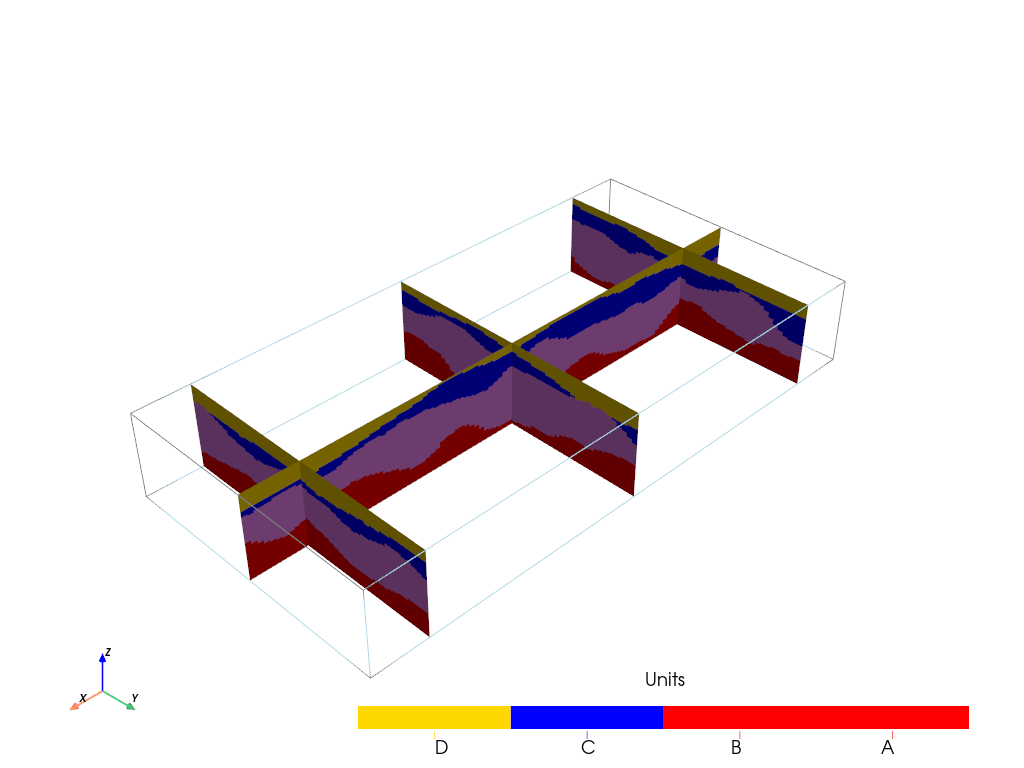

In [22]:

T1.plot_units(v_ex=3, slicex=(0.1, 0.5, 0.9), slicey=0.5)

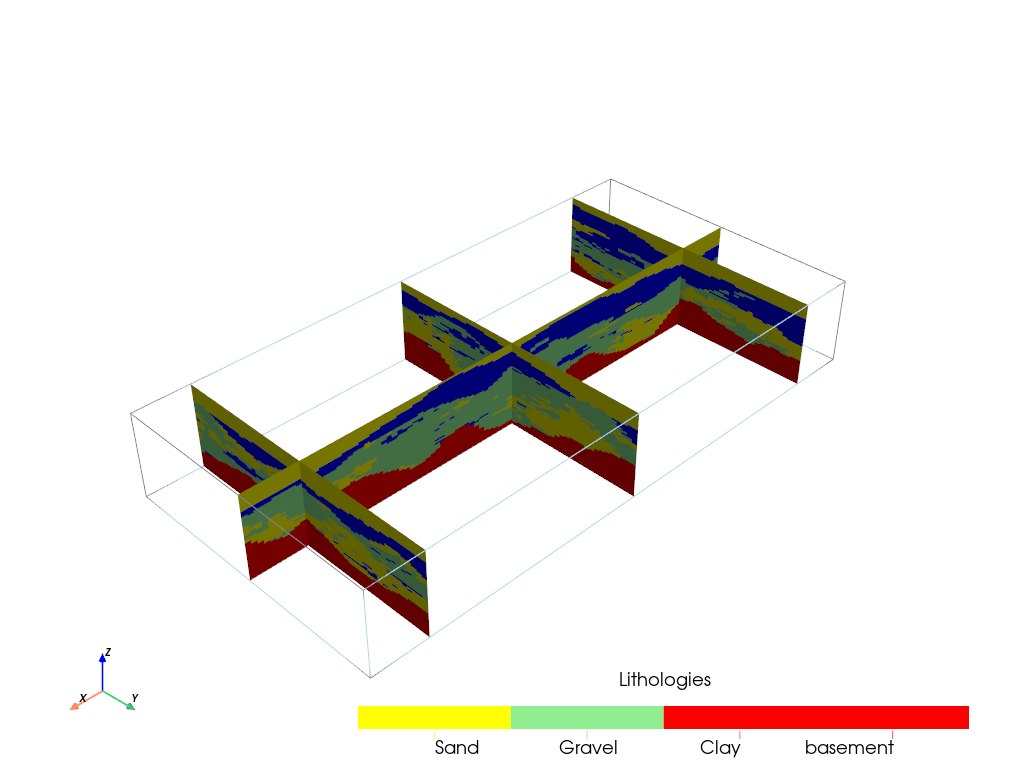

In [23]:

T1.plot_facies(v_ex=3, slicex=(0.1, 0.5, 0.9), slicey=0.5)

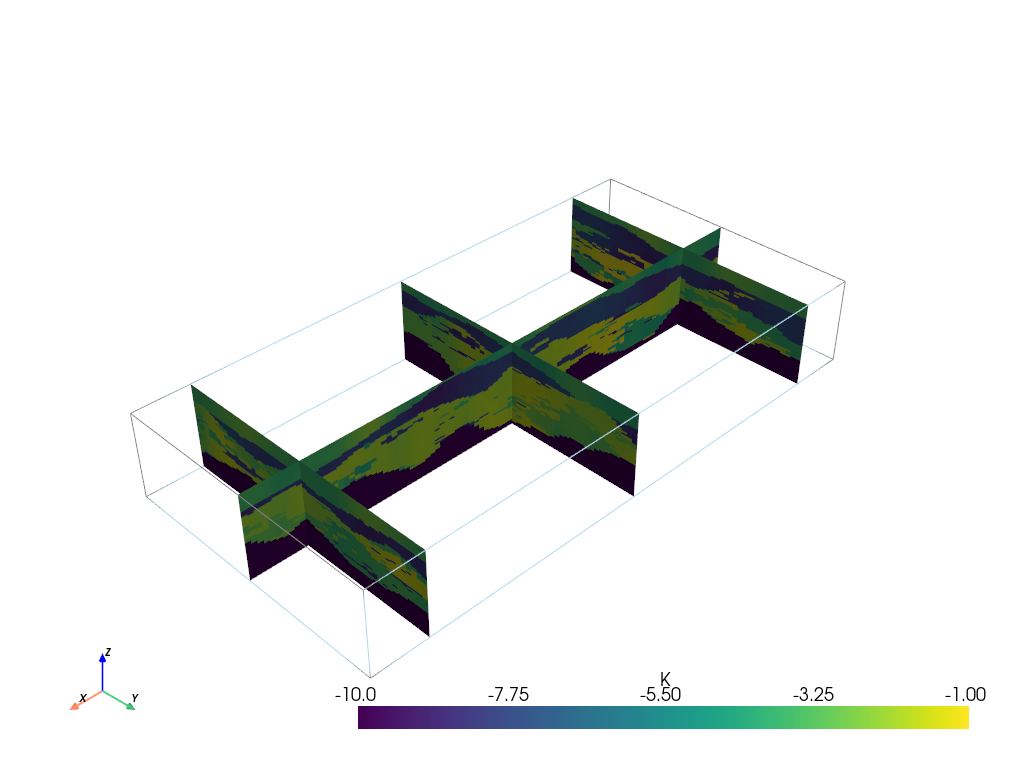

In [24]:

T1.plot_prop("K", v_ex=3, slicex=(0.1, 0.5, 0.9), slicey=0.5)

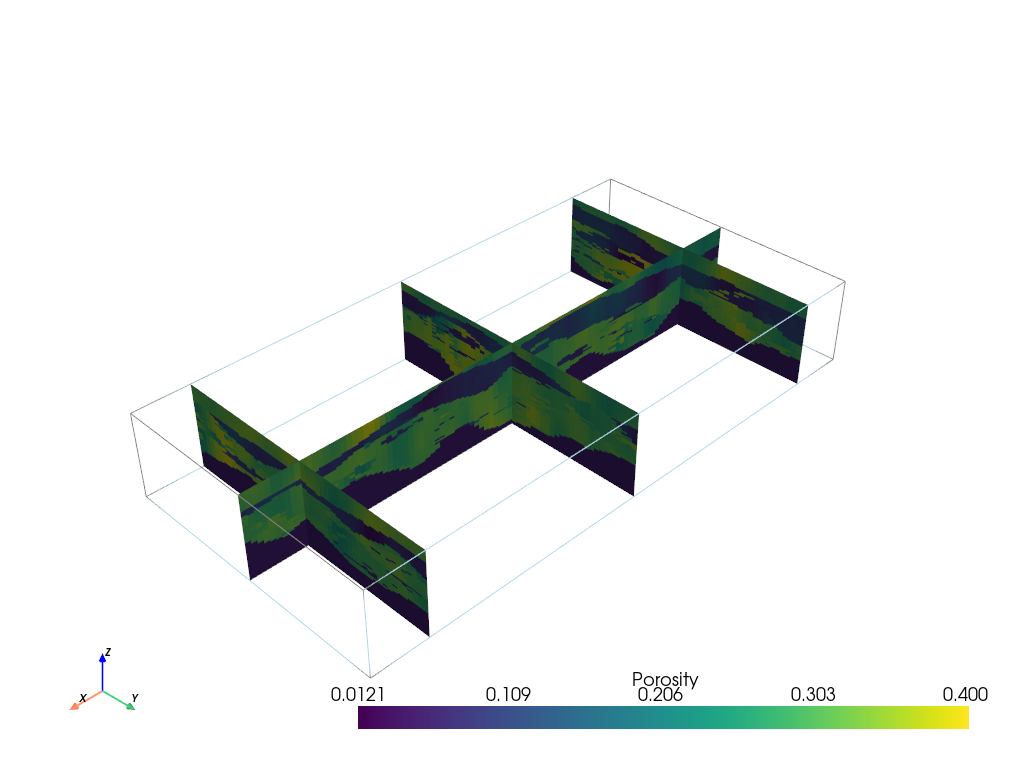

In [25]:

T1.plot_prop("Porosity", v_ex=3, slicex=(0.1, 0.5, 0.9), slicey=0.5)

In [26]:
# ArchPy.inputs.save_project(T1)

## Heterogeneous

### Flow model

In [118]:
import ArchPy.ap_mf
from ArchPy.ap_mf import archpy2modflow, array2cellids
import flopy as fp

In [119]:
mf6_exe_path = "../../../../exe/mf6.exe"

In [120]:
archpy_flow = archpy2modflow(T1, exe_name=mf6_exe_path, model_dir="layered_hetero")  # create the modflow model
archpy_flow.create_sim(grid_mode="layers", iu=0, unit_limit=None, lay_sep=[1, 1, 3, 1], factor_x=2, factor_y=2, factor_z=2)  # create the simulation object and choose a certain discretization


Simulation created
To retrieve the simulation, use the get_sim() method


In [129]:
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True, k_average_method="anisotropic")  # set the hydraulic conductivity

In [122]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [123]:
sim.ims.remove()
inner_dvclose = 1e-5
ims = fp.mf6.ModflowIms(sim, complexity="moderate", inner_dvclose=inner_dvclose)

In [124]:
# add BC at left and right on all layers
h1 = .3
h2 = 0
T_1 = 10  # temperature at left boundary
T_2 = 10  # temperature at right boundary
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1, T_1))

chd1 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-1")

chd_data = []
a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2, T_2))

chd2 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-2")

In [125]:
# add an injection well in the middle of the model
well_data = []
Q_well = 0.0015  # m3/s
T_well = 7  # temperature of the injected water
cellid_well = (2, T1.ny // 2, T1.nx // 2)
well_data.append((cellid_well, Q_well, T_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, auxiliary="TEMPERATURE", pname="WEL-INJ")

# production well
well_data = []
Q_well = -Q_well # m3/s
cellid_well = (2, T1.ny // 2, int(T1.nx // 2.5))
well_data.append((cellid_well, Q_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, pname="WEL-PROD")

In [126]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 290 based on size of stress_period_data
    writing package chd-2...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 300 based on size of stress_period_data
    writing package wel-inj...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-prod...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY

(True, [])

In [127]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

# add different arrays to the vtk object
heads = archpy_flow.get_heads()
vtk.add_array(heads, name="heads")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")
vtk.add_array(np.log10(gwf.npf.k33.array), name="Kzz")
vtk.add_array(gwf.npf.k.array / gwf.npf.k33.array, name="aniso")
vtk.add_array(np.flip(archpy_flow.upscaled_facies[1], axis=1), name="prop")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="heads", cmap="gist_ncar", edge_opacity=.3)

# pl.show(screenshot="../../../figures/articles/archpy 2/raw/flow_lay_he.png", window_size=[1300, 900], auto_close=False)
# pl.show(screenshot="E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/flow_lay_he.png", window_size=[1300, 900], auto_close=False)
pl.show()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
heads = archpy_flow.get_heads()

In [ ]:
# default font size
matplotlib.rcParams.update({'font.size': 20})

Text(0, 0.5, 'Z [m]')

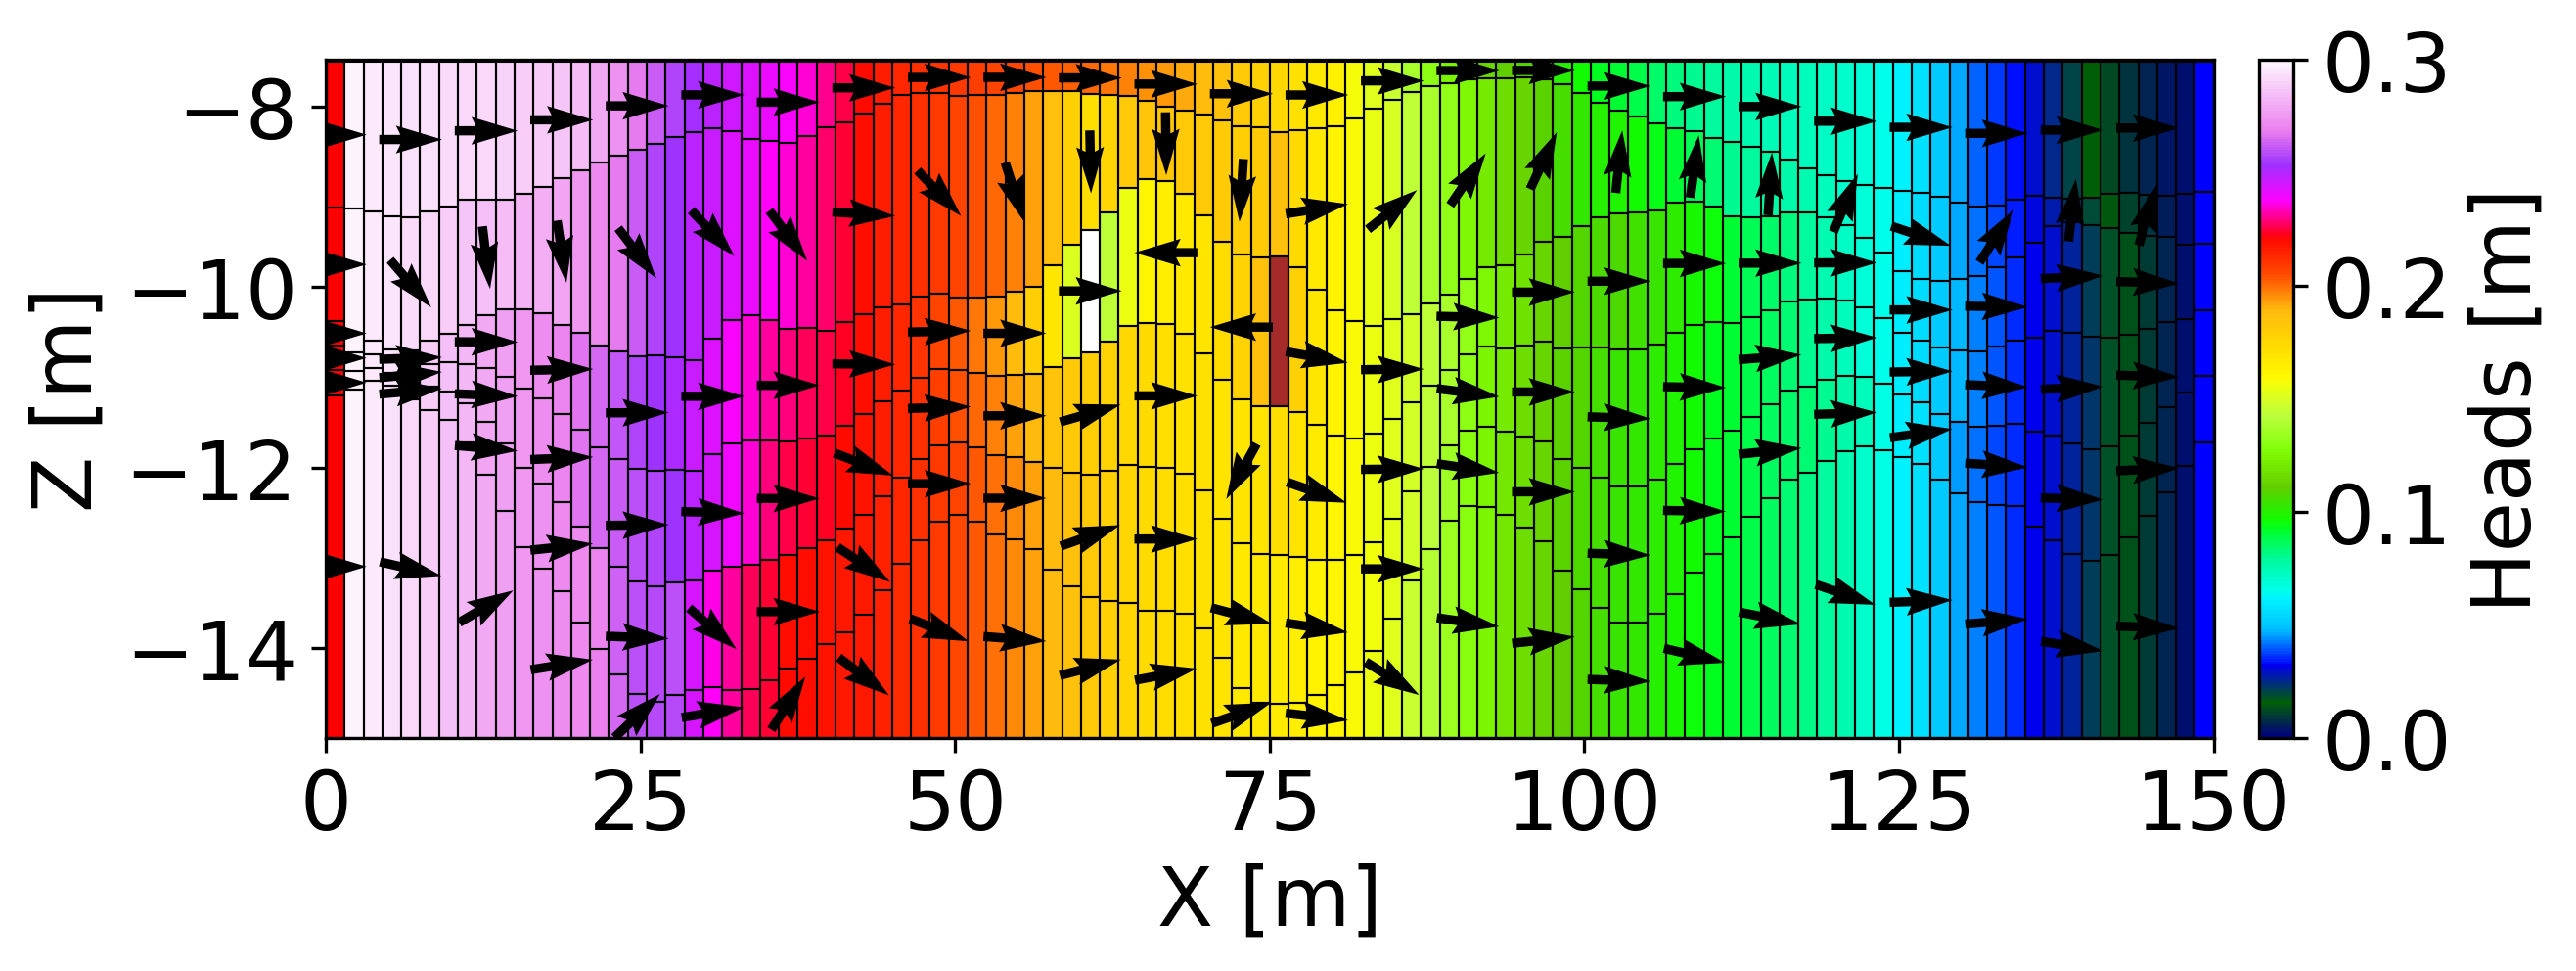

In [ ]:
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300)
cross_section = PlotCrossSection(model=gwf, line={"row": 25})
# cross_section.plot_array(np.log10(gwf.npf.k.array), cmap="Blues", ax=ax)
cont = cross_section.plot_array(heads, cmap="gist_ncar", ax=ax)
# cont = cross_section.contour_array(heads, ax=ax, levels=np.arange(0, 0.25, 0.02), linewidths=3)
# plt.clabel(cont, inline=True, fontsize=20, fmt="%.2f", colors="black")
cross_section.plot_bc("CHD-1", color="red", ax=ax)
cross_section.plot_bc("CHD-2", color="blue", ax=ax)
cross_section.plot_bc("WEL-INJ", color="brown", ax=ax)
cross_section.plot_bc("WEL-PROD", color="white", ax=ax)
cross_section.plot_vector(qx, qy, qz, color="black", normalize=True, hstep=4, kstep=1, ax=ax, scale=30)
cross_section.plot_grid(linewidth=0.5, color="black")
plt.colorbar(cont, ax=ax, label="Heads [m]", orientation="vertical", pad=0.02)
plt.xlabel("X [m]")
plt.ylabel("Z [m]")

# fig.savefig("E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/flow_lay_he_cross_section.png", dpi=300, bbox_inches="tight")

In [ ]:
np.random.seed(15)

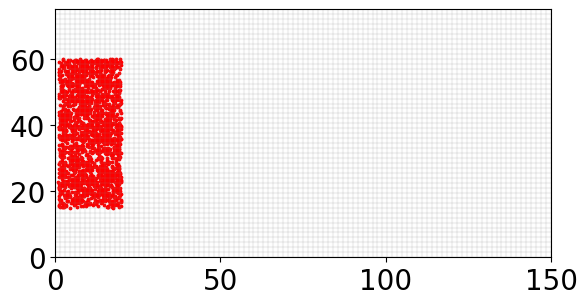

In [ ]:
n = 2000
xp = np.random.uniform(1, 20, n)
yp = np.random.uniform(T1.yg[-1]*0.2 + T1.yg[0], T1.yg[-1]*0.8, n)
zp = np.random.uniform(-9, -11, n)
list_p_coords = []
for i in range(n):
    list_p_coords.append((xp[i], yp[i], zp[i]))
plt.scatter(xp, yp, c="red", s=3)
gwf.modelgrid.plot(alpha=.1)

In [128]:
archpy_flow.prt_create(prt_name="test_prt", workspace="ws_prt", trackdir="forward", list_p_coords=list_p_coords)
archpy_flow.set_porosity(prop_key="Porosity", iu=0, ifa=0, ip=0)
archpy_flow.prt_run(silent=False)

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model test_prt...
    writing model name file...
    writing package mip...
    writing package dis...
    writing package prp...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:42:11 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to furthe

In [32]:
df_all = archpy_flow.prt_get_pathlines()

In [33]:
plt.style.use('seaborn-v0_8-pastel')

In [34]:
# default font size
matplotlib.rcParams.update({'font.size': 8})

Text(0, 0.5, 'Y [m]')

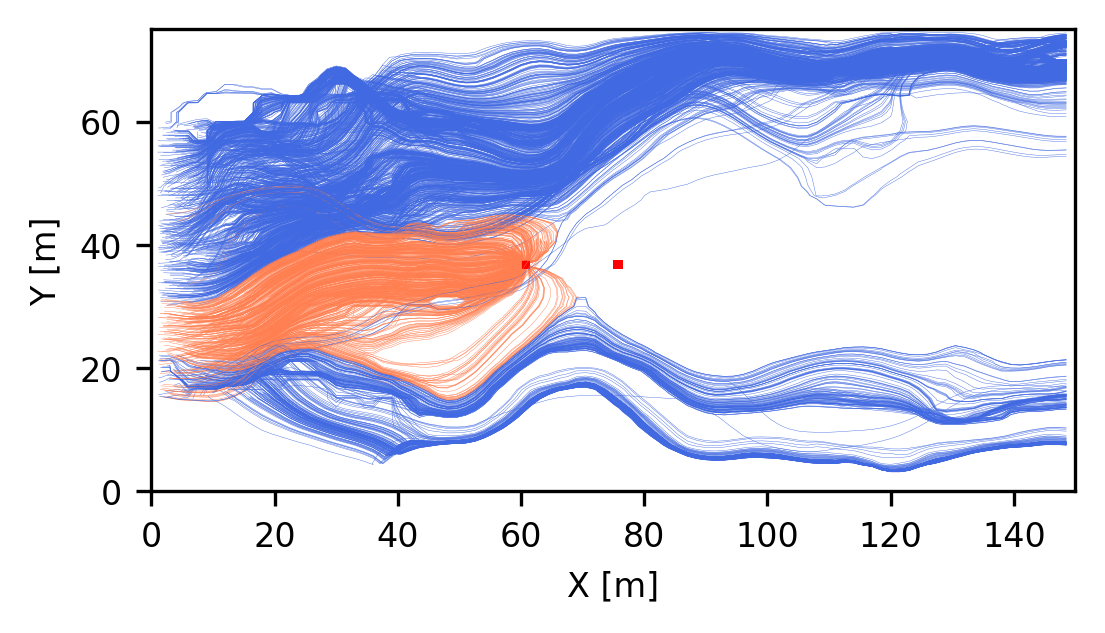

In [35]:
plt.figure(figsize=(5, 2), dpi=300)

ml = fp.plot.PlotMapView(model=gwf, layer=2)
ml.plot_bc("WEL")
for i in range(1, 2000):
    xmax = df_all.loc[df_all.irpt==i].iloc[-1].x
    path = df_all.loc[df_all.irpt == i]
    if xmax < 65:
        plt.plot(path["x"], path["y"], linewidth=.1, color="coral")
    else: 
        plt.plot(path["x"], path["y"], linewidth=.1, color="royalblue")


plt.xlabel("X [m]")
plt.ylabel("Y [m]")

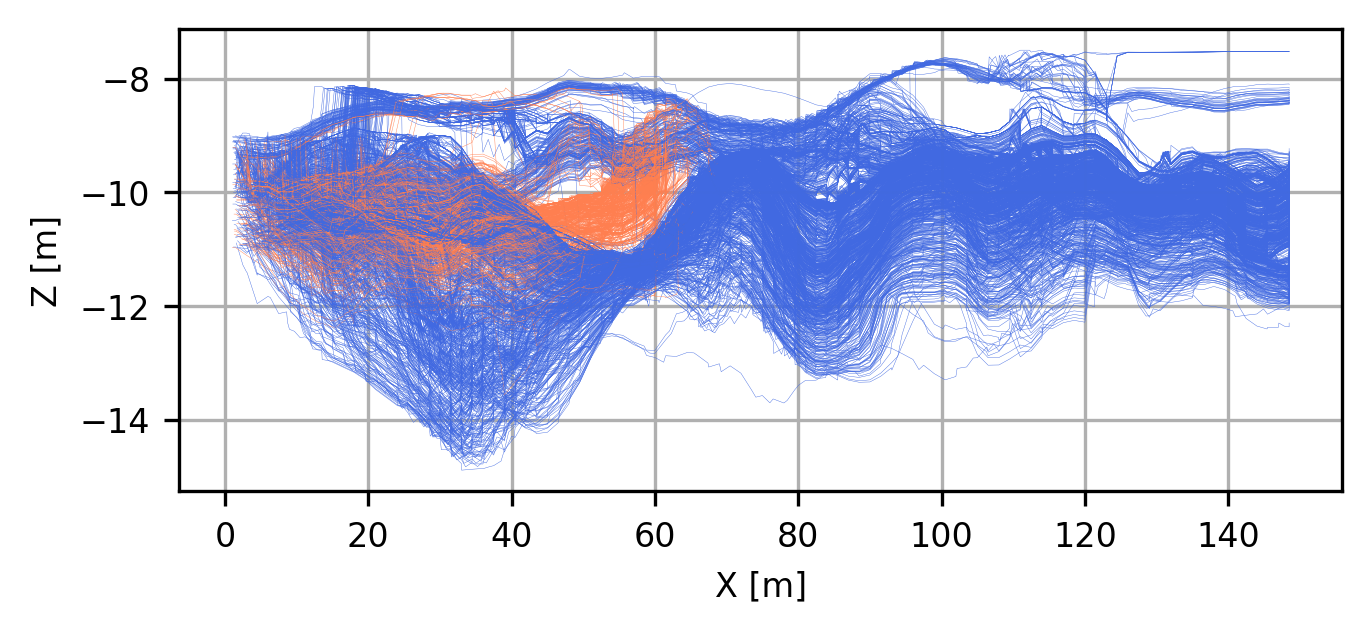

In [36]:
plt.figure(figsize=(5, 2), dpi=300)

# gwf.modelgrid.plot(alpha=.1)
for i in range(1, 2000):
    xmax = df_all.loc[df_all.irpt==i].iloc[-1].x
    path = df_all.loc[df_all.irpt == i]
    if xmax < 65:
        plt.plot(path["x"], path["z"], linewidth=.1, color="coral")
    else: 
        plt.plot(path["x"], path["z"], linewidth=.1, color="royalblue")
plt.xlabel("X [m]")
plt.ylabel("Z [m]")
plt.grid()

In [37]:
t_well_layhe = []
t_bc_layhe = []
for i in range(1, 2000):
    xmax = df_all.loc[df_all.irpt==i].iloc[-1].x
    if xmax < 65:
        t_well_layhe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)
    else:
        t_bc_layhe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)

t_well_layhe = np.array(t_well_layhe)
t_bc_layhe = np.array(t_bc_layhe)
np.save("t_well_layhe.npy", t_well_layhe)
np.save("t_bc_layhe.npy", t_bc_layhe)

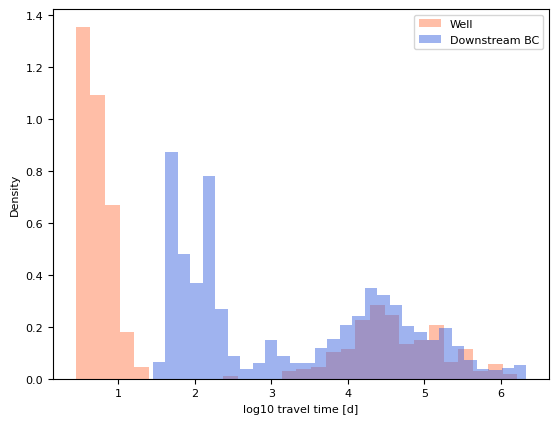

In [38]:
plt.hist(np.log10(t_well_layhe / 86400), density=True, alpha=.5, label="Well", color="coral", bins=30)
plt.hist(np.log10(t_bc_layhe / 86400), density=True, alpha=.5, label="Downstream BC", color="royalblue", bins=30)

plt.xlabel("log10 travel time [d]")
plt.ylabel("Density")

plt.legend()

In [39]:
import ArchPy.ap_mf
# default font size
matplotlib.rcParams.update({'font.size': 8})

In [50]:
df_p = archpy_flow.prt_get_facies_path_particle(5, fac_time=1/86400)
df = archpy_flow.prt_get_pathlines(5)

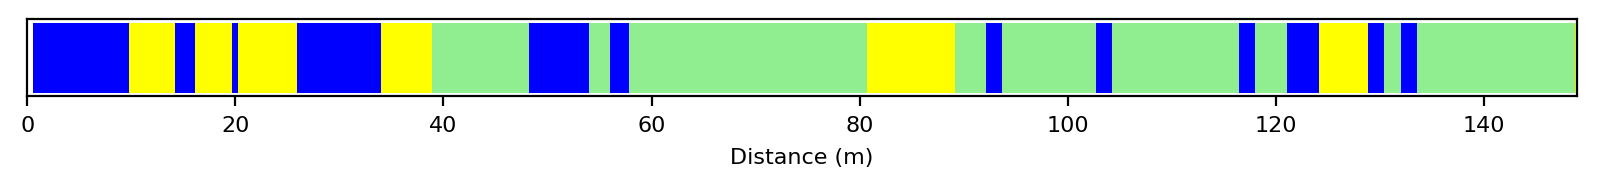

In [80]:
df_p = archpy_flow.prt_get_facies_path_particle(1426, facies_archpy=True)
ArchPy.ap_mf.plot_particle_facies_sequence(T1, df=df_p, plot_distance=True, proportions=False, plot_time=False, resampling="d")

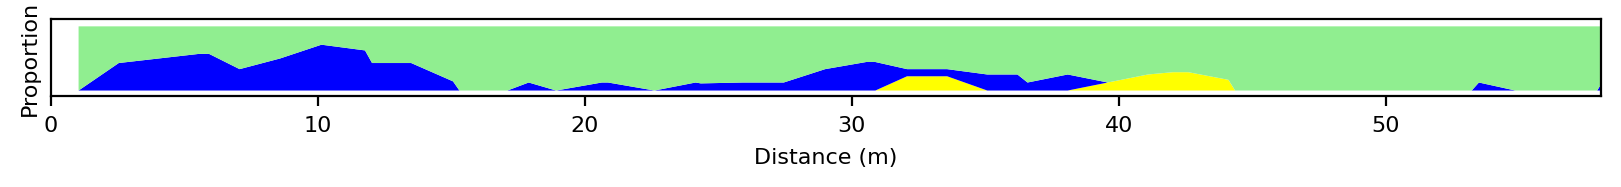

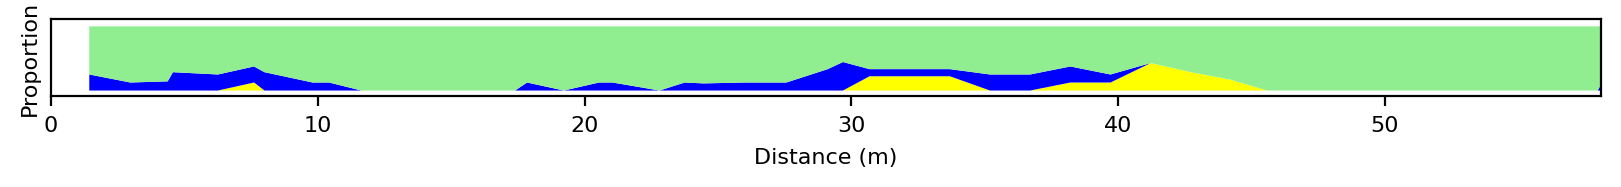

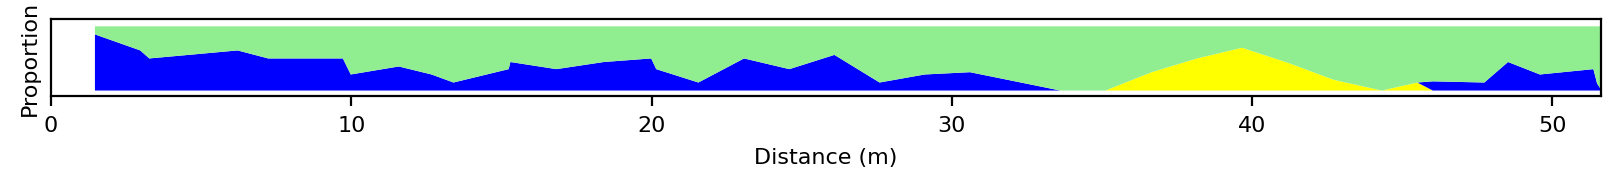

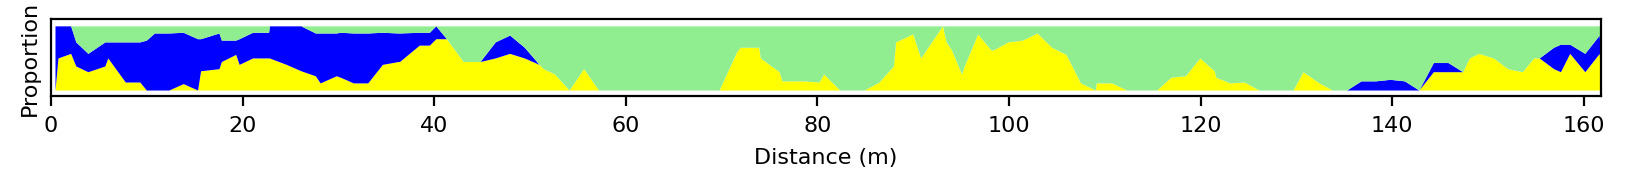

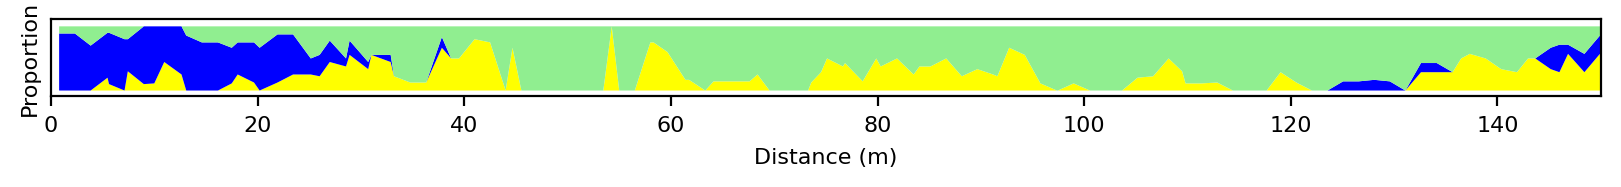

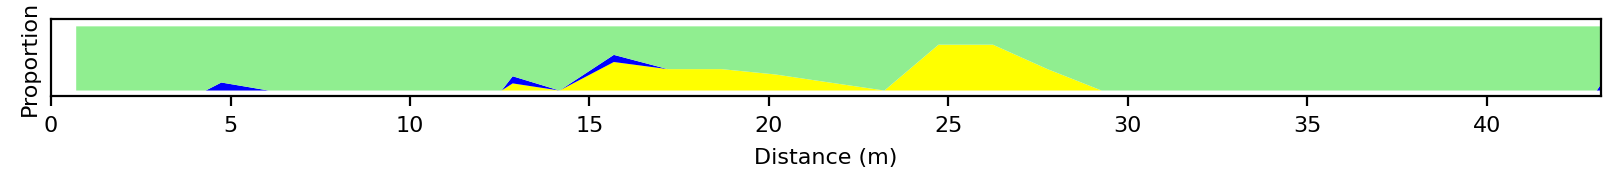

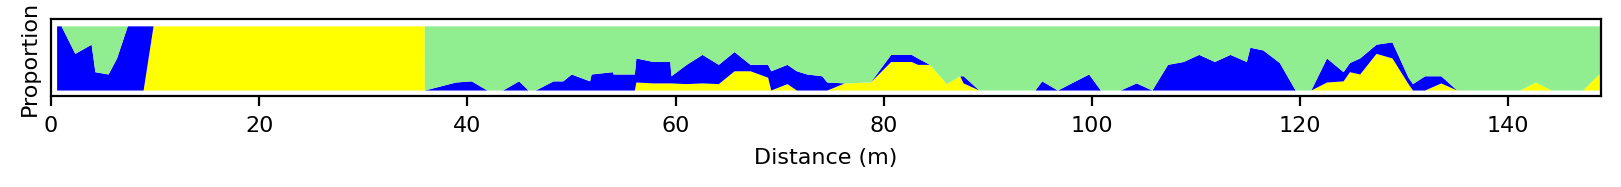

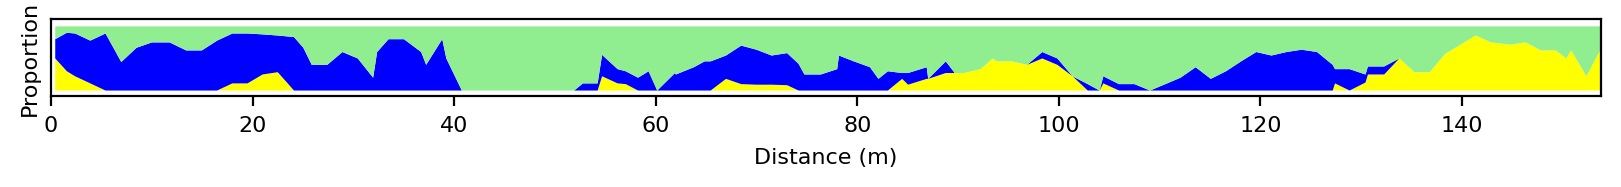

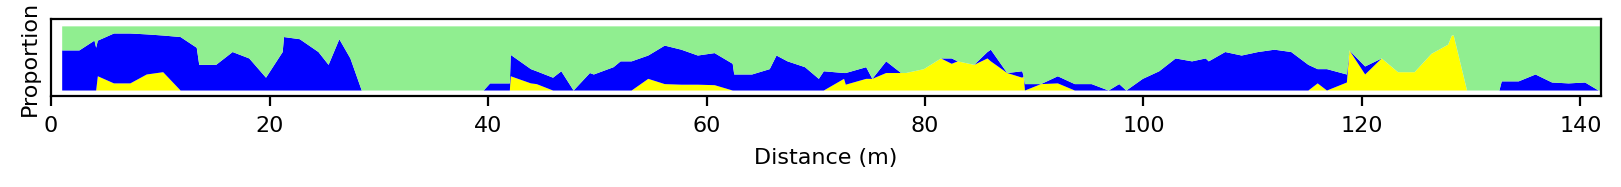

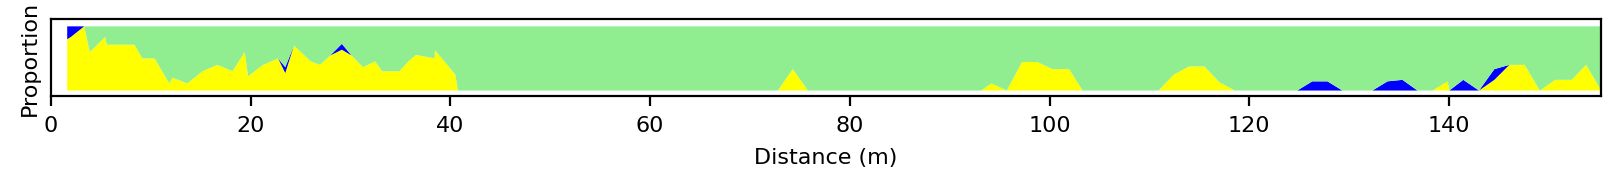

In [77]:
np.random.seed(1312)
for i in range(10):
    ip = np.random.randint(2000)
    df_p = archpy_flow.prt_get_facies_path_particle(ip)
    ArchPy.ap_mf.plot_particle_facies_sequence(T1, df=df_p, plot_distance=True, proportions=True, plot_time=False)

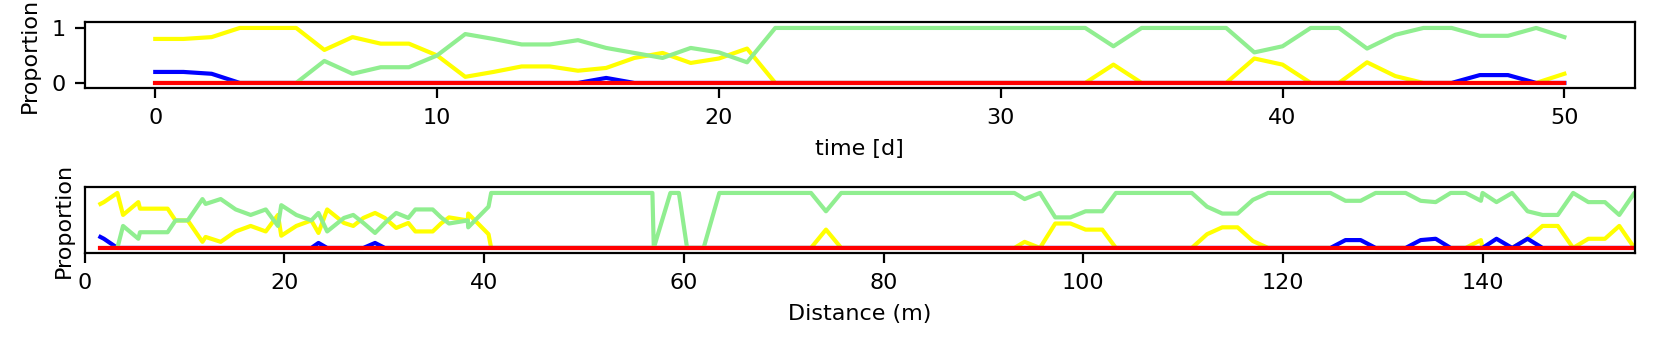

In [42]:
ArchPy.ap_mf.plot_particle_facies_sequence(T1, df=df_p, plot_distance=True, proportions=True, plot_time=True, time_unit="d", resampling="d")

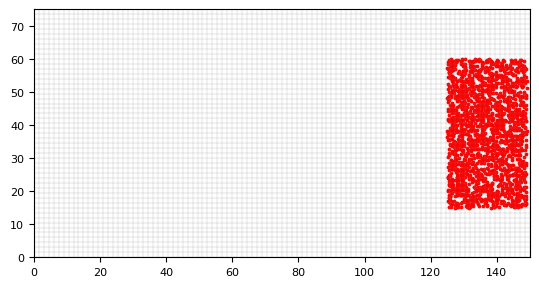

In [43]:
n = 2000
xp = np.random.uniform(125, 149, n)
yp = np.random.uniform(T1.yg[-1]*0.2 + T1.yg[0], T1.yg[-1]*0.8, n)
zp = np.random.uniform(-9, -11, n)
list_p_coords = []
for i in range(n):
    list_p_coords.append((xp[i], yp[i], zp[i]))
plt.scatter(xp, yp, c="red", s=3)
gwf.modelgrid.plot(alpha=.1)

In [44]:
archpy_flow.prt_create(prt_name="test_prt", workspace="ws_prt", trackdir="backward", list_p_coords=list_p_coords)
archpy_flow.set_porosity(prop_key="Porosity", iu=0, ifa=0, ip=0)
archpy_flow.prt_run(silent=False)

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model test_prt...
    writing model name file...
    writing package mip...
    writing package dis...
    writing package prp...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:42:11 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to furthe

In [45]:
df_all = archpy_flow.prt_get_pathlines()

Text(0, 0.5, 'Y [m]')

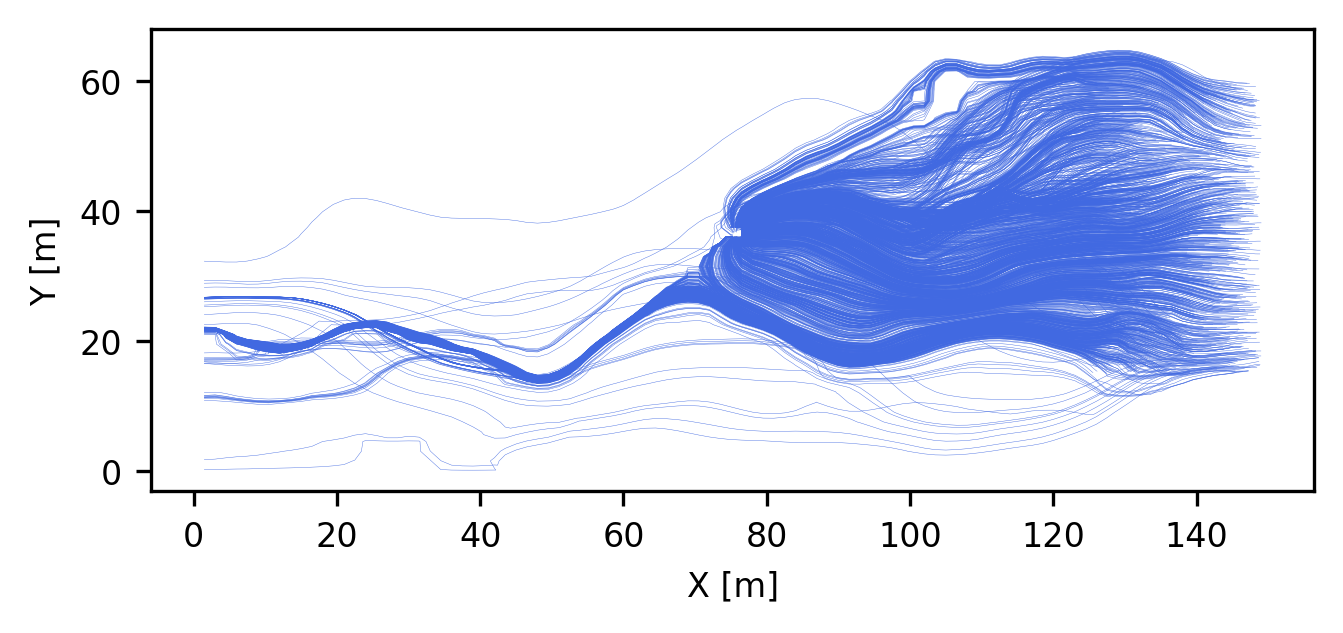

In [46]:
plt.figure(figsize=(5, 2), dpi=300)

# gwf.modelgrid.plot(alpha=.1)
for i in range(1, 2000):
    path = df_all.loc[df_all.irpt == i]
    plt.plot(path["x"], path["y"], linewidth=.1, color="royalblue")

plt.xlabel("X [m]")
plt.ylabel("Y [m]")

## ArchPy mode - heterogeneous

In [72]:
archpy_flow = archpy2modflow(T1, exe_name=mf6_exe_path, model_dir="archpy_mode_hetero")  # create the modflow model
archpy_flow.create_sim(grid_mode="archpy", iu=0, unit_limit=None)  # create the simulation object and choose a certain discretization
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True, k_average_method="anisotropic")  # set the hydraulic conductivity

Simulation created
To retrieve the simulation, use the get_sim() method


In [73]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [74]:
sim.ims.remove()
inner_dvclose = 1e-5
ims = fp.mf6.ModflowIms(sim, complexity="moderate", inner_dvclose=inner_dvclose)

In [75]:
import flopy as fp

In [76]:
# add BC at left and right on all layers
h1 = .3
h2 = 0
T_1 = 10  # temperature at left boundary
T_2 = 10  # temperature at right boundary
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1, T_1))

chd1 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-1")

chd_data = []
a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2, T_2))

chd2 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-2")

Wells at ($75.0, 25.0, 4.5$) and ($60.0, 25.0, 4.5$)

In [77]:
# add an injection well in the middle of the model
well_data = []
Q_well = 0.0015  # m3/s
T_well = 7  # temperature of the injected water
cellid_well = (21, T1.ny // 2, T1.nx // 2)
well_data.append((cellid_well, Q_well, T_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, auxiliary="TEMPERATURE", pname="WEL-INJ")

# production well
well_data = []
Q_well = -0.0015  # m3/s
cellid_well = (21, T1.ny // 2, int(T1.nx // 2.5))
well_data.append((cellid_well, Q_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, pname="WEL-PROD")

In [78]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2500 based on size of stress_period_data
    writing package chd-2...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2500 based on size of stress_period_data
    writing package wel-inj...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-prod...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURV

(True, [])

In [79]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(heads, name="heads")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="heads", cmap="gist_ncar", edge_opacity=0.3, clim=[0, 0.3])
# pl.show(screenshot="E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/flow_archpy_he.png", window_size=[1300, 900], auto_close=False)
# pl.show()

Actor (0x26687df2ec0)
  Center:                     (75.0, 37.5, -33.75)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    0.000E+00, 1.500E+02
  Y Bounds                    0.000E+00, 7.500E+01
  Z Bounds                    -4.500E+01, -2.250E+01
  User matrix:                Identity
  Has mapper:                 True

Property (0x26687df0e20)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Anisotropy rotation:         0.0
  Backface culling:            0
  Base ior:                    1.5
  Class name:                  "vtkOpenGLProperty"
  Coat color:                  (1.0, 1.0, 1.0)
  Coat ior:                    2.0
  Coat normal scale:           1.0
  Coat roughness:              0.0
  Coat strength:               0.0
  Color:      

In [80]:
heads = archpy_flow.get_heads()

Text(0, 0.5, 'Z [m]')

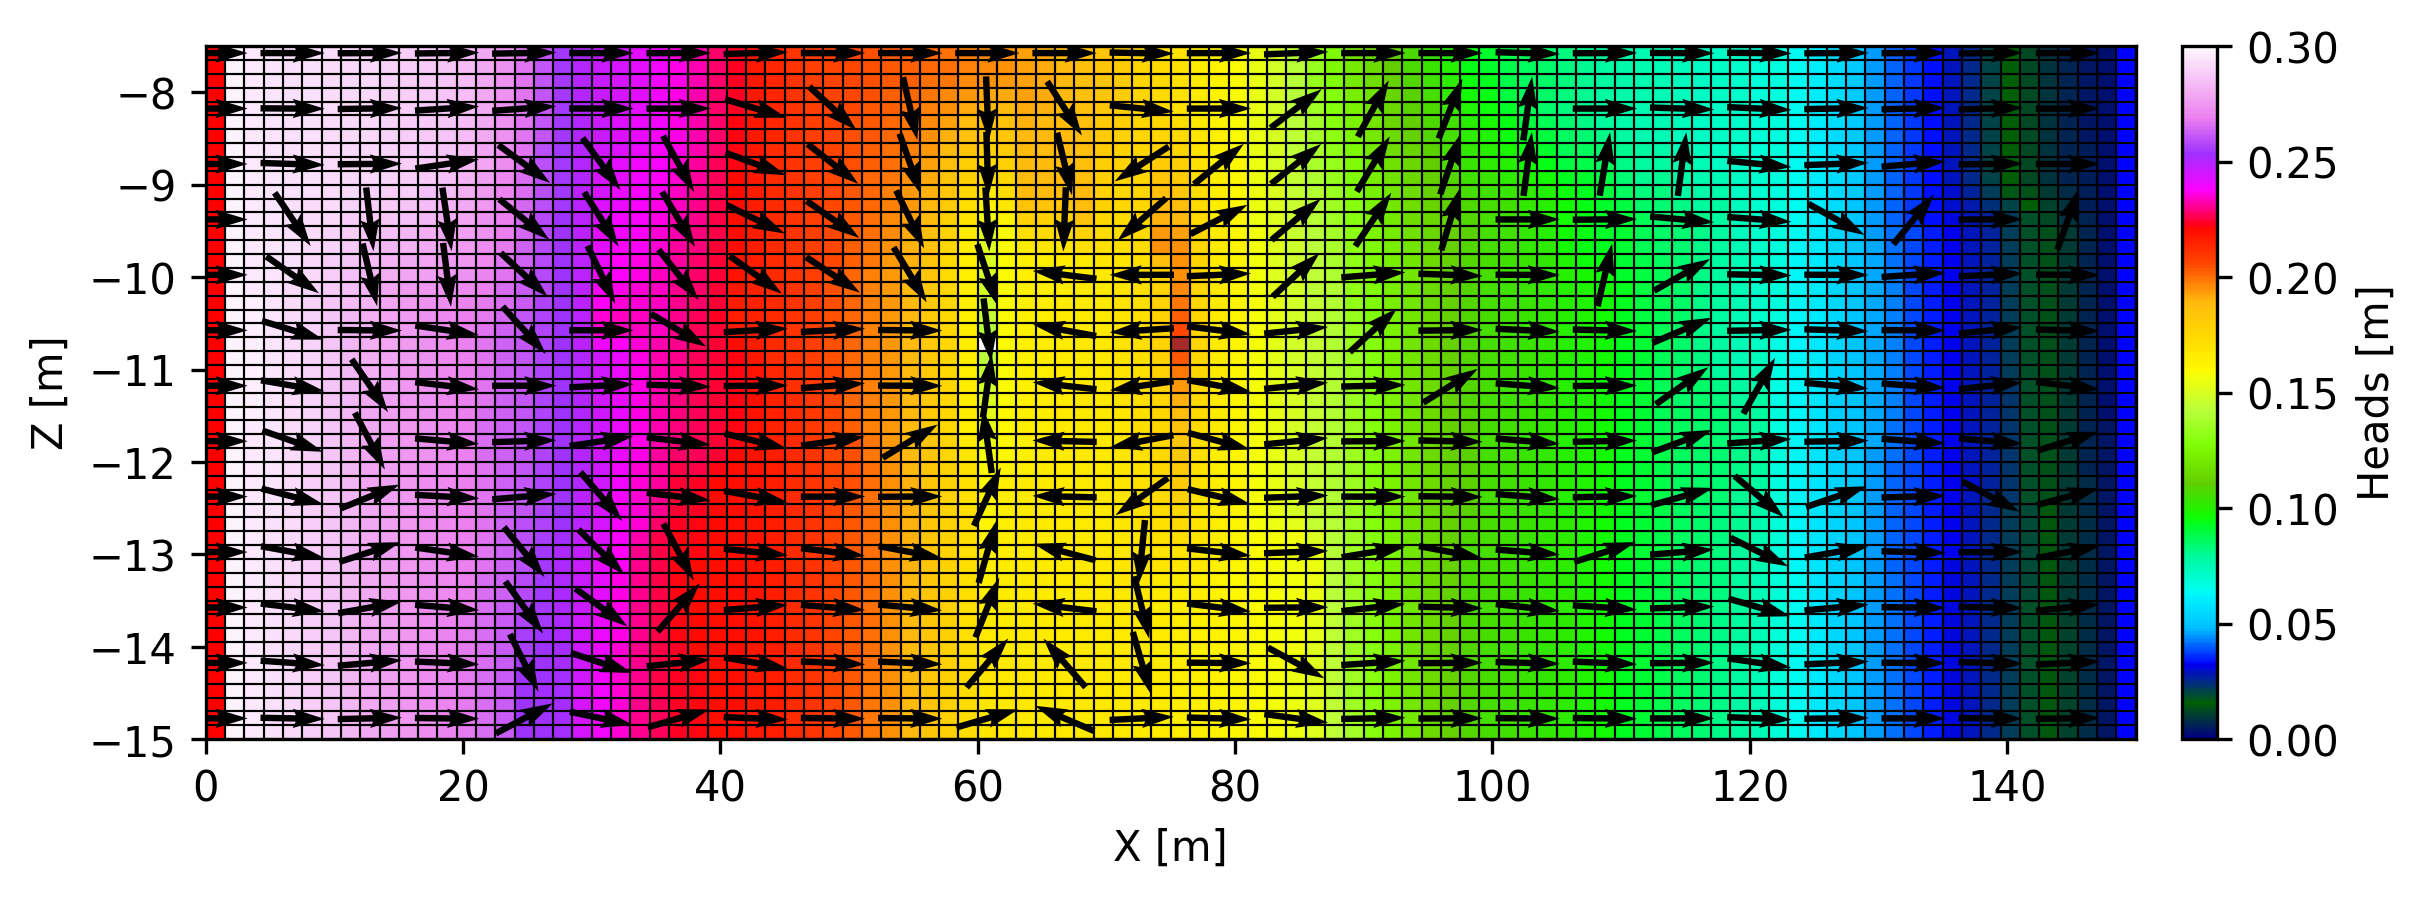

In [81]:
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300)
cross_section = PlotCrossSection(model=gwf, line={"row": 25})
# cross_section.plot_array(np.log10(gwf.npf.k.array), cmap="Blues", ax=ax)
cont = cross_section.plot_array(heads, cmap="gist_ncar", ax=ax)
# cont = cross_section.contour_array(heads, ax=ax, levels=np.arange(0, 0.25, 0.02), linewidths=3)
# plt.clabel(cont, inline=True, fontsize=20, fmt="%.2f", colors="black")
cross_section.plot_bc("CHD-1", color="red", ax=ax)
cross_section.plot_bc("CHD-2", color="blue", ax=ax)
cross_section.plot_bc("WEL-INJ", color="brown", ax=ax)
cross_section.plot_bc("WEL-PROD", color="white", ax=ax)
cross_section.plot_vector(qx, qy, qz, color="black", normalize=True, kstep=4, hstep=4, ax=ax, scale=30)
cross_section.plot_grid(linewidth=0.5, color="black")
plt.colorbar(cont, ax=ax, label="Heads [m]", orientation="vertical", pad=0.02)
plt.xlabel("X [m]")
plt.ylabel("Z [m]")

# fig.savefig("E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/archpy_he_cross_section.png", dpi=300, bbox_inches="tight")

In [82]:
np.random.seed(15)

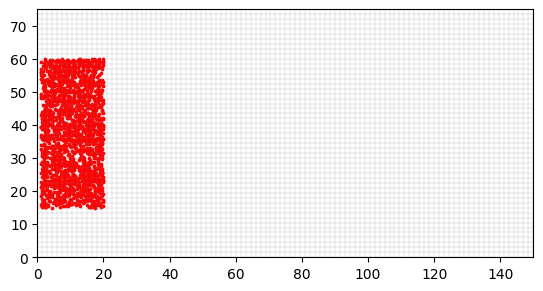

In [83]:
n = 2000
xp = np.random.uniform(1, 20, n)
yp = np.random.uniform(T1.yg[-1]*0.2 + T1.yg[0], T1.yg[-1]*0.8, n)
zp = np.random.uniform(-9, -11, n)
list_p_coords = []
for i in range(n):
    list_p_coords.append((xp[i], yp[i], zp[i]))
plt.scatter(xp, yp, c="red", s=3)
gwf.modelgrid.plot(alpha=.1)

In [84]:
archpy_flow.prt_create(prt_name="test_prt", workspace="ws_prt", trackdir="forward", list_p_coords=list_p_coords)
archpy_flow.set_porosity(prop_key="Porosity", iu=0, ifa=0, ip=0)
archpy_flow.prt_run(silent=False)

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model test_prt...
    writing model name file...
    writing package mip...
    writing package dis...
    writing package prp...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:42:11 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to furthe

In [60]:
df_all = archpy_flow.prt_get_pathlines()

Text(0, 0.5, 'Y [m]')

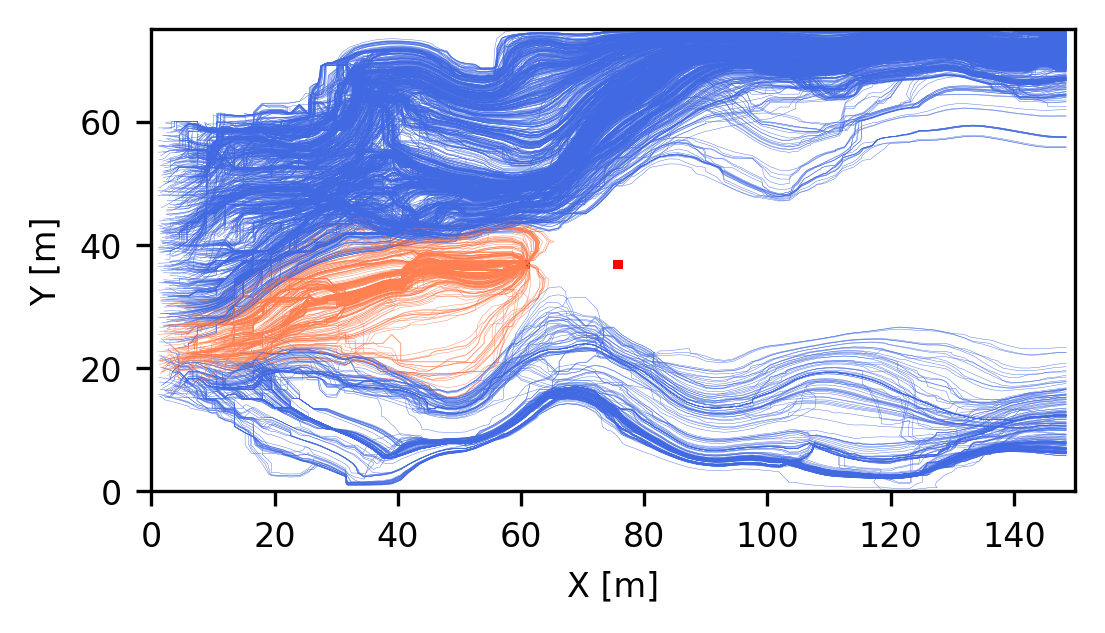

In [61]:
plt.figure(figsize=(5, 2), dpi=300)


ml = fp.plot.PlotMapView(model=gwf, layer=21)

for i in range(1, 2000):
    xmax = df_all.loc[df_all.irpt==i].iloc[-1].x
    path = df_all.loc[df_all.irpt == i]
    if xmax < 65:
        plt.plot(path["x"], path["y"], linewidth=.1, color="coral")
    else: 
        plt.plot(path["x"], path["y"], linewidth=.1, color="royalblue")

ml.plot_bc("WEL")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")


In [62]:
t_well_aphe = []
t_bc_aphe = []
for i in range(1, 2000):
    xmax = df_all.loc[df_all.irpt==i].iloc[-1].x
    if xmax < 65:
        t_well_aphe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)
    else:
        t_bc_aphe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)

t_well_aphe = np.array(t_well_aphe)
t_bc_aphe = np.array(t_bc_aphe)
np.save("t_well_aphe.npy", t_well_aphe)
np.save("t_bc_aphe.npy", t_bc_aphe)

In [63]:
print(t_well_aphe.shape)
print(t_well_layhe.shape)

(387,)
(553,)


In [64]:
df_plot_well = pd.DataFrame([np.log10(t_well_aphe / 86400), np.log10(t_well_layhe / 86400)]).T
df_plot_well.columns = ["Ap-he", "Lay-he"]

df_plot_bc = pd.DataFrame([np.log10(t_bc_aphe / 86400), np.log10(t_bc_layhe / 86400)]).T
df_plot_bc.columns = ["Ap-he", "Lay-he"]

Text(0.5, 1.0, 'Downstream BC')

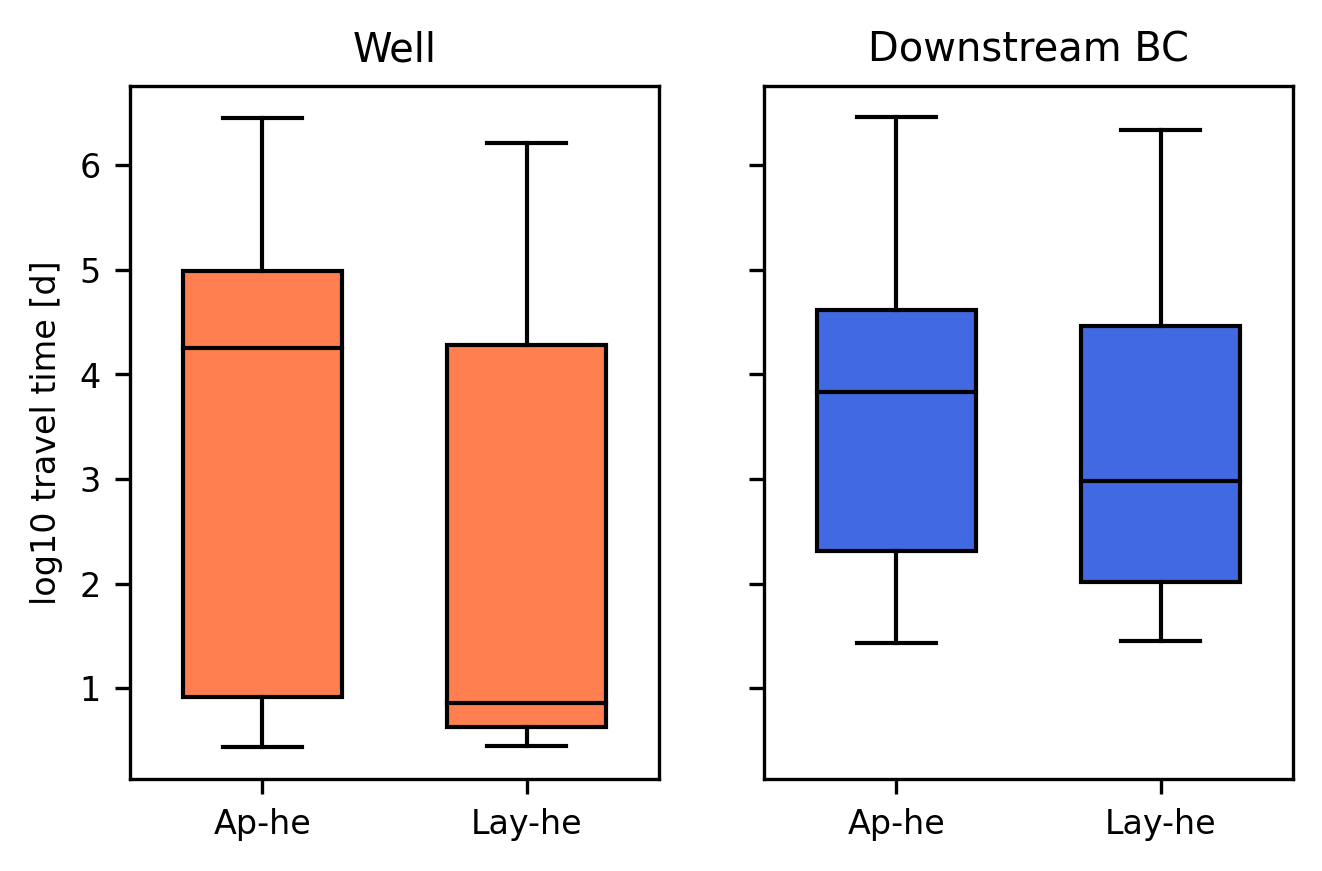

In [65]:
fig, ax= plt.subplots(1, 2, figsize=(5, 3), dpi=300, sharey=True)

axi = ax[0]
positions = [0, 1]
df_plot_well.plot.box(positions=positions, ax=axi, patch_artist=True, showfliers=True, widths=0.6,
                boxprops=dict(facecolor="coral"),
                whiskerprops=dict(color="black"),
                medianprops=dict(color="black"),
                capprops=dict(color="black"))
axi.set_ylabel("log10 travel time [d]")
axi.set_title("Well")

axi = ax[1]
positions = [0, 1]
df_plot_bc.plot.box(positions=positions, ax=axi, patch_artist=True, showfliers=True, widths=0.6,
                boxprops=dict(facecolor="royalblue"),
                whiskerprops=dict(color="black"),
                medianprops=dict(color="black"),
                capprops=dict(color="black"))

axi.set_title("Downstream BC")

In [66]:
import ArchPy.ap_mf

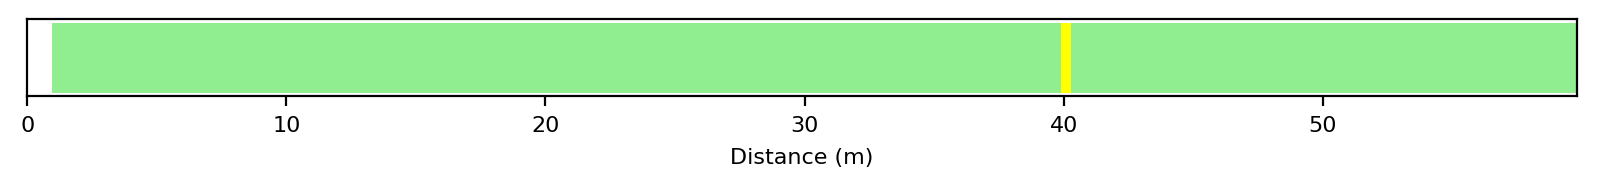

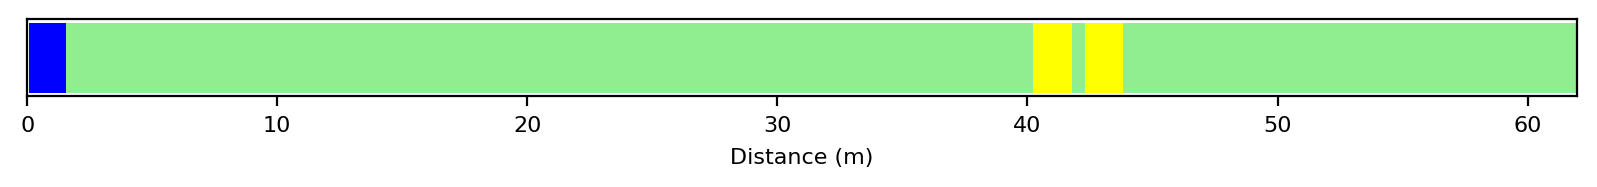

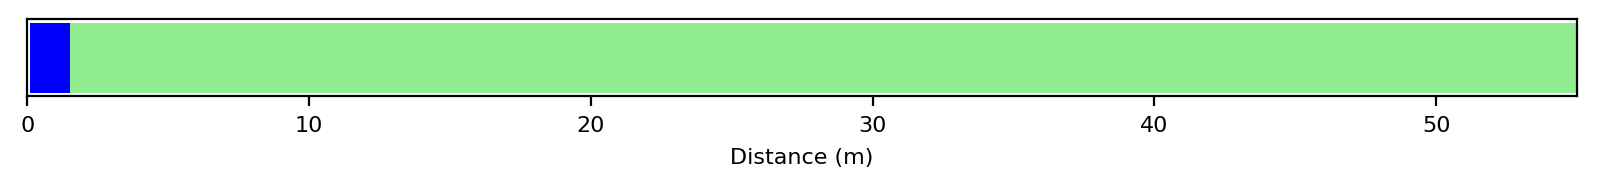

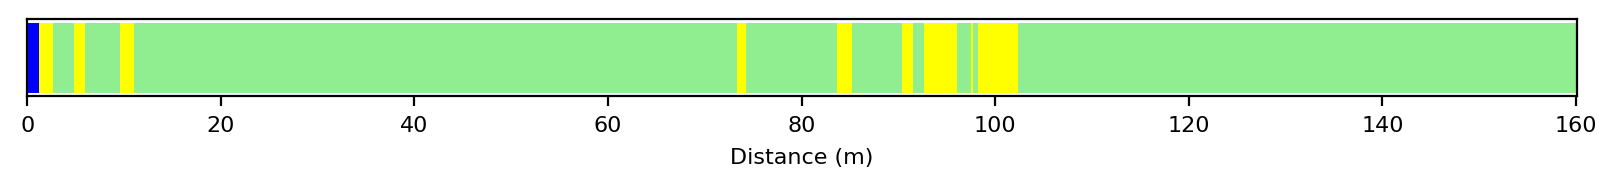

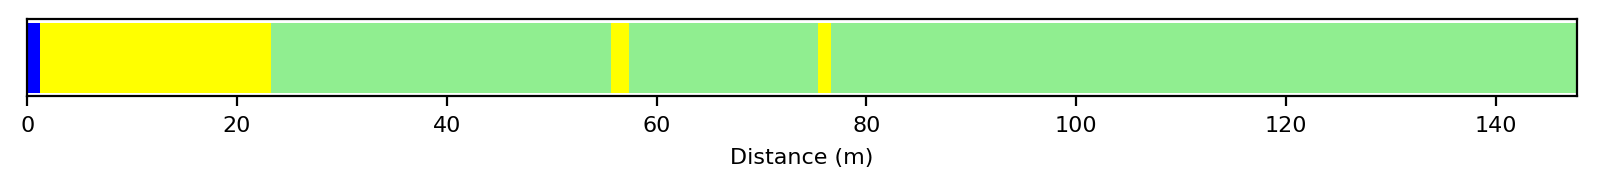

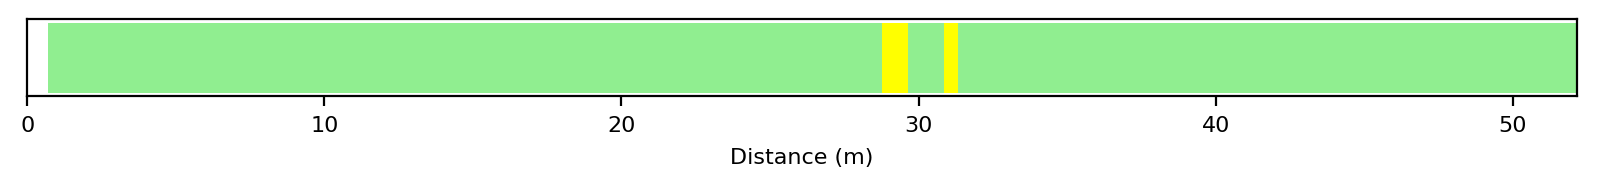

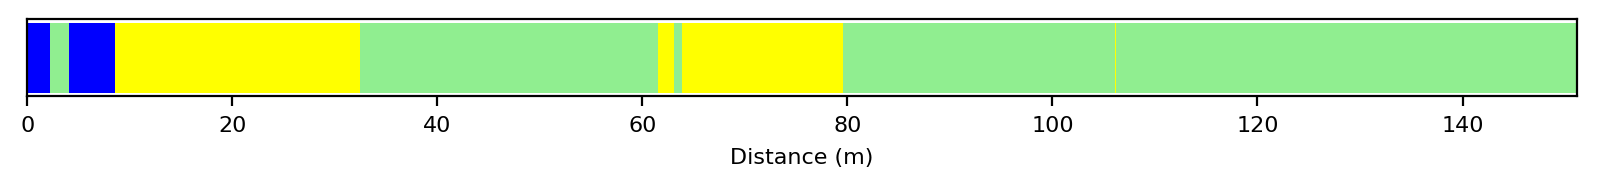

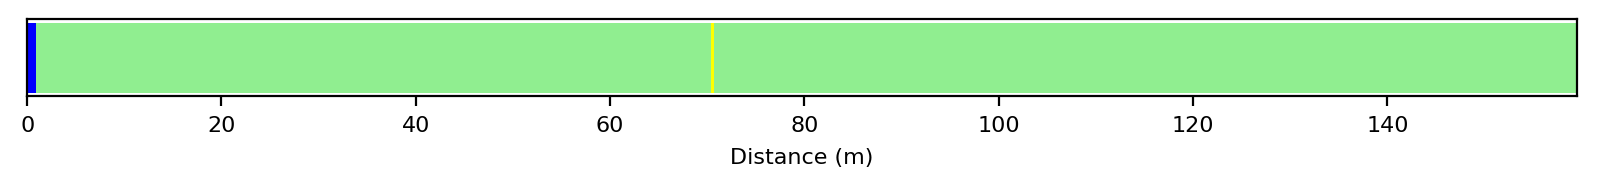

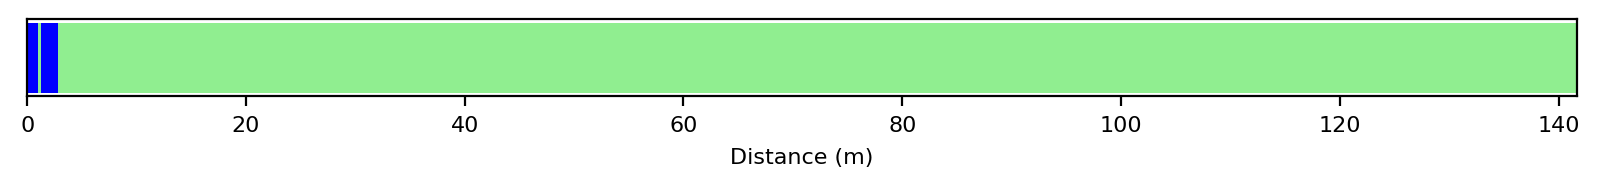

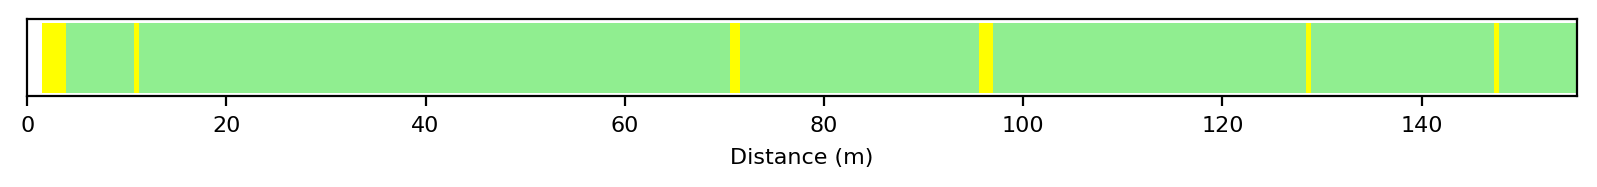

In [67]:
np.random.seed(1312)
for i in range(10):
    ip = np.random.randint(2000)
    df_p = archpy_flow.prt_get_facies_path_particle(ip)
    ArchPy.ap_mf.plot_particle_facies_sequence(T1, df=df_p, plot_distance=True, proportions=False, plot_time=False)

In [68]:
df_all = archpy_flow.prt_get_pathlines()
df = df_all.loc[df_all.irpt==1639]
df

irpt   icell  kper  kstp  imdl  iprp  ilay  izone  istatus  ireason  \
302634  1639  112011     1     1     1     1    23      0        1        0   
302635  1639  112011     1     1     1     1    23      0        1        1   
302636  1639  112012     1     1     1     1    23      0        1        1   
302637  1639  112013     1     1     1     1    23      0        1        1   
302638  1639  107013     1     1     1     1    22      0        1        1   
...      ...     ...   ...   ...   ...   ...   ...    ...      ...      ...   
302857  1639  145298     1     1     1     1    30      0        1        1   
302858  1639  145299     1     1     1     1    30      0        1        1   
302859  1639  150299     1     1     1     1    31      0        1        1   
302860  1639  155299     1     1     1     1    32      0        1        1   
302861  1639  155300     1     1     1     1    32      0        5        3   

        trelease             t           x          y          z  name  
302634       0.0  0.000000e+00   15.032296  43.731413 -10.856335   NaN  
302635       0.0  1.348638e+05   16.500000  44.317118 -10.844073   NaN  
302636       0.0  2.766853e+05   18.000000  44.653829 -10.868594   NaN  
302637       0.0  4.074523e+05   19.360677  44.967908 -10.800000   NaN  
302638       0.0  4.215806e+05   19.500000  44.996270 -10.790632   NaN  
...          ...           ...         ...        ...        ...   ...  
302857       0.0  1.068147e+07  147.000000  71.097159 -11.947910   NaN  
302858       0.0  1.068421e+07  147.483205  71.187996 -12.000000   NaN  
302859       0.0  1.069094e+07  148.479073  71.420662 -12.150000   NaN  
302860       0.0  1.069111e+07  148.500000  71.426583 -12.154149   NaN  
302861       0.0  1.069111e+07  148.500000  71.426583 -12.154149   NaN  

[228 rows x 16 columns]

In [69]:
np.random.seed(15)

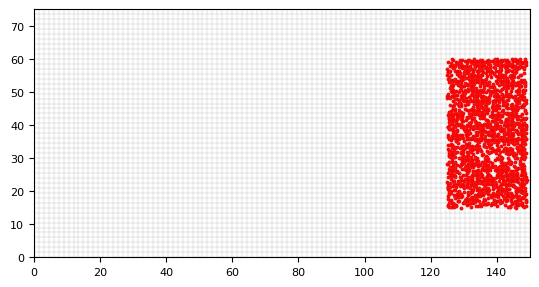

In [70]:
n = 2000
xp = np.random.uniform(125, 149, n)
yp = np.random.uniform(T1.yg[-1]*0.2 + T1.yg[0], T1.yg[-1]*0.8, n)
zp = np.random.uniform(-9, -11, n)
list_p_coords = []
for i in range(n):
    list_p_coords.append((xp[i], yp[i], zp[i]))
plt.scatter(xp, yp, c="red", s=3)
gwf.modelgrid.plot(alpha=.1)

In [71]:
archpy_flow.prt_create(prt_name="test_prt", workspace="ws_prt", trackdir="backward", list_p_coords=list_p_coords)
archpy_flow.set_porosity(prop_key="Porosity", iu=0, ifa=0, ip=0)
archpy_flow.prt_run(silent=False)

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model test_prt...
    writing model name file...
    writing package mip...
    writing package dis...
    writing package prp...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:42:11 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to furthe

In [72]:
df_all = archpy_flow.prt_get_pathlines()

Text(0, 0.5, 'Y [m]')

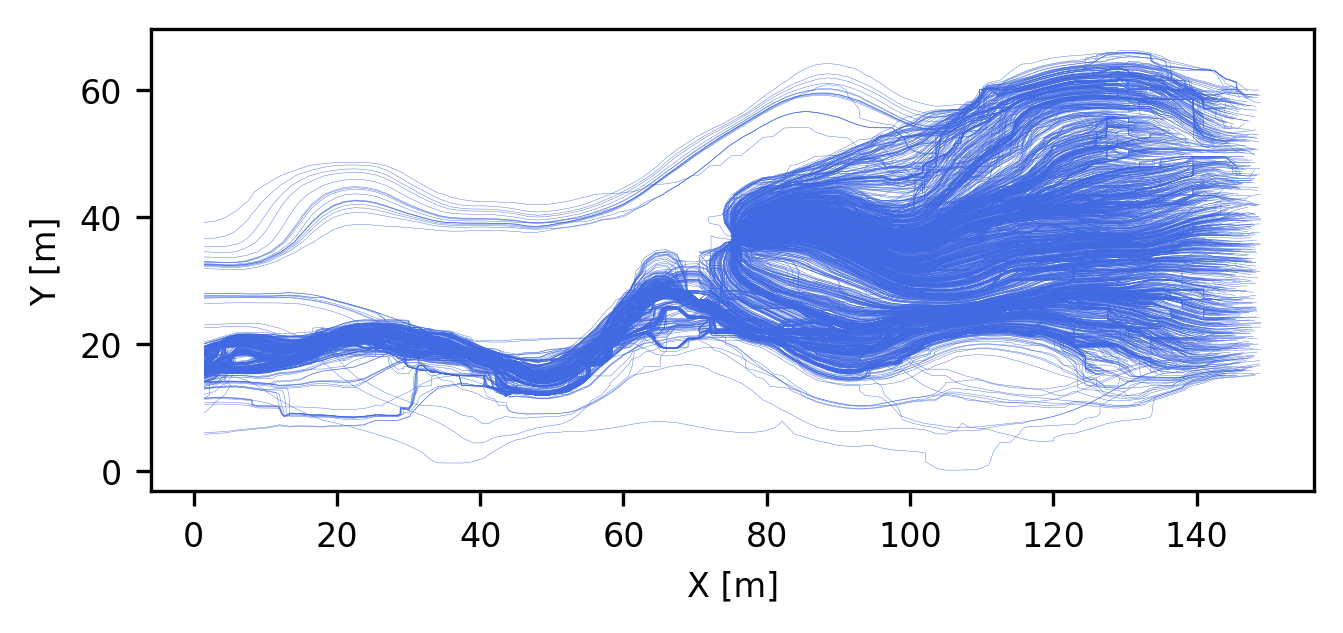

In [73]:
plt.figure(figsize=(5, 2), dpi=300)

# gwf.modelgrid.plot(alpha=.1)
for i in range(1, 2000):
    path = df_all.loc[df_all.irpt == i]
    plt.plot(path["x"], path["y"], linewidth=.1, color="royalblue")

plt.xlabel("X [m]")
plt.ylabel("Y [m]")

In [74]:
self = archpy_flow

In [75]:
sim_dir = self.sim_prt.sim_path
csv_name = self.sim_prt.prt[0].oc.trackcsv_filerecord.array[0][0]
csv_path = os.path.join(sim_dir, csv_name)
df = pd.read_csv(csv_path)
df = df.loc[df.irpt==9]

In [76]:
time_ordered = df["t"].values.copy()
time_ordered *= 1/86400
dt = np.diff(time_ordered)

# add a column to track distance traveled
distances = ((df[["x", "y", "z"]].iloc[1:].values - df[["x", "y", "z"]].iloc[:-1].values)**2).sum(1)**0.5

# store everything in a new dataframe
df_all = pd.DataFrame(columns=["dt", "time", "distance", "cum_distance", "x", "y", "z"])
df_all["dt"] = dt
df_all["time"] = time_ordered[1:]
df_all["distance"] = distances
df_all["cum_distance"] = df_all["distance"].cumsum()
df_all["x"] = df["x"].values[1:]
df_all["y"] = df["y"].values[1:]
df_all["z"] = df["z"].values[1:]

In [77]:
nx = self.get_gwf().modelgrid.ncol
ny = self.get_gwf().modelgrid.nrow
cells_path = ArchPy.ap_mf.get_locs(df.icell-1, nx, ny)
cells_path = np.array(cells_path)[1:]

# check that no cells path exceed the grid
cells_path[:, 0][cells_path[:, 0] >= self.T1.nz] = self.T1.nz - 1
cells_path[:, 1][cells_path[:, 1] >= self.T1.ny] = self.T1.ny - 1
cells_path[:, 2][cells_path[:, 2] >= self.T1.nx] = self.T1.nx - 1

In [78]:
facies = self.T1.get_facies(0, 0, all_data=False)
facies = np.flip(np.flipud(facies), axis=1)

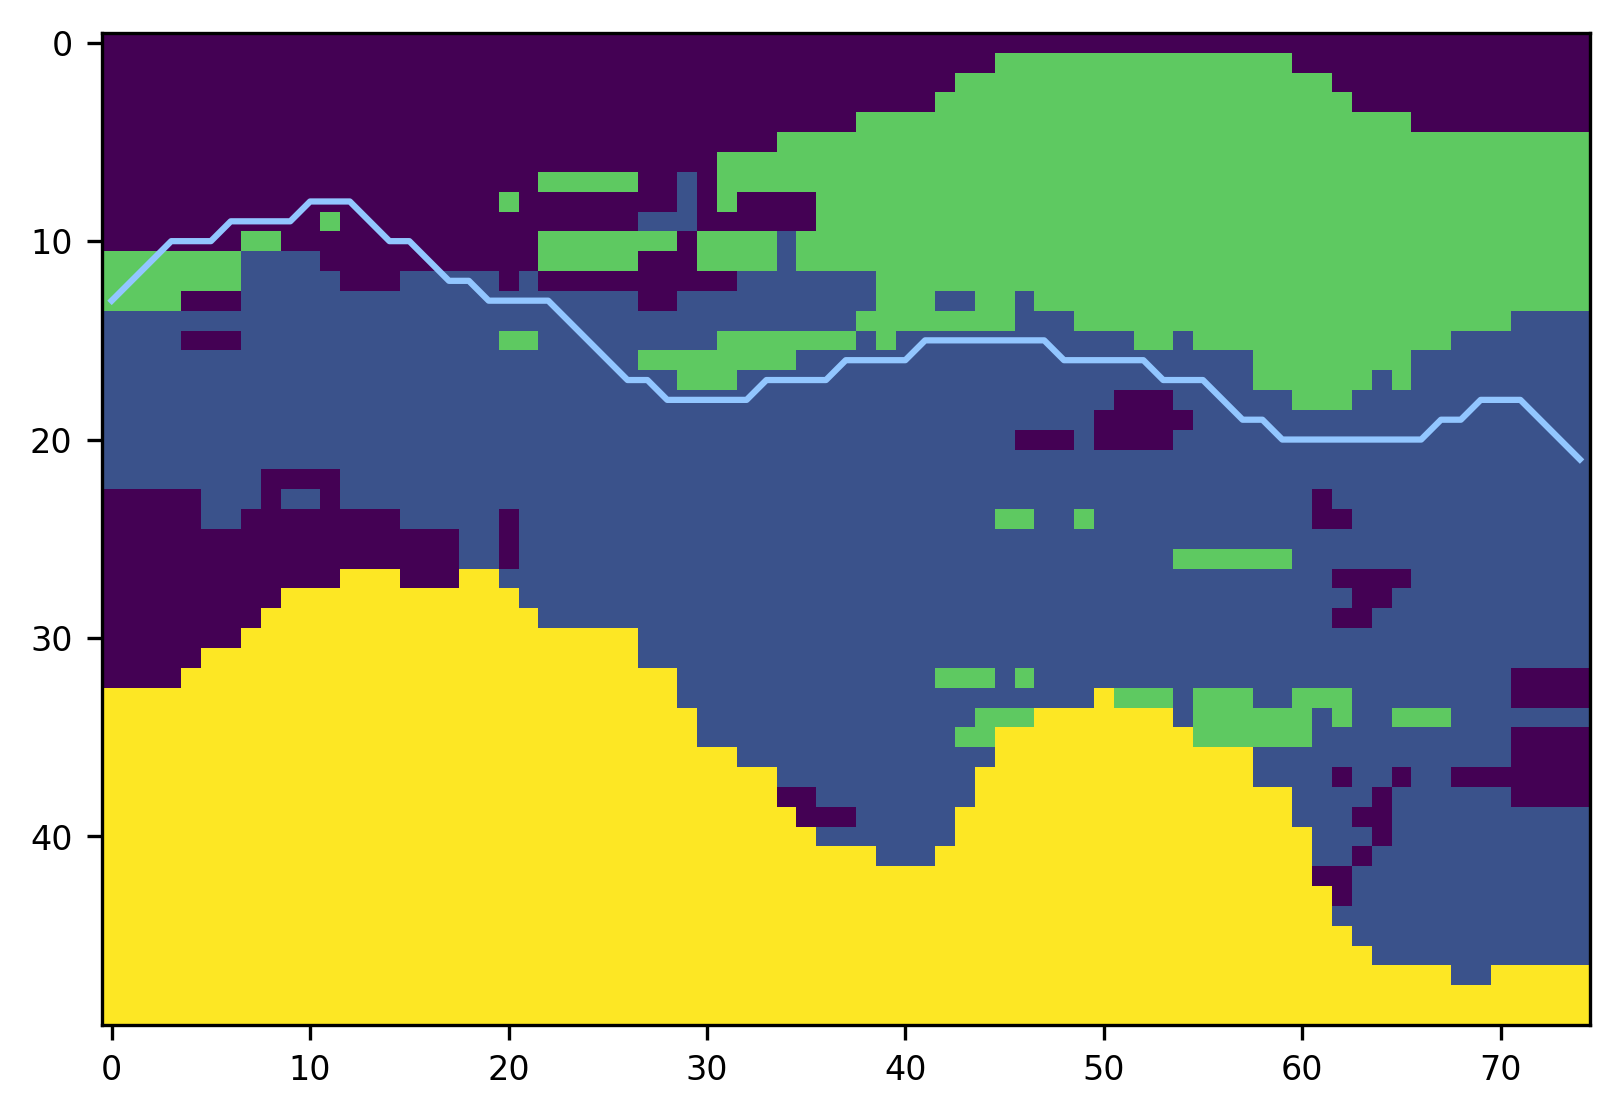

In [79]:
plt.figure(dpi=300)
plt.imshow(facies[:, cells_path[:, 1], cells_path[:, 2]], vmin=1, vmax=5)
plt.plot(cells_path[:, 0])

## NR-heterogeneous mode

In [89]:
archpy_flow = archpy2modflow(T1, exe_name=mf6_exe_path, model_dir="new_res_hetero")  # create the modflow model
archpy_flow.create_sim(grid_mode="new_resolution", iu=0, unit_limit=None, factor_x=4, factor_y=2, factor_z=2)  # create the simulation object and choose a certain discretization
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True)  # set the hydraulic conductivity

Simulation created
To retrieve the simulation, use the get_sim() method


In [90]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [91]:
gwf.modelgrid.nlay * gwf.modelgrid.nrow * gwf.modelgrid.ncol

15625

In [92]:
sim.ims.remove()
inner_dvclose = 1e-5
ims = fp.mf6.ModflowIms(sim, complexity="moderate", inner_dvclose=inner_dvclose)

In [93]:
# add BC at left and right on all layers
h1 = .3
h2 = 0
T_1 = 10  # temperature at left boundary
T_2 = 10  # temperature at right boundary
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1, T_1))

chd1 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-1")

chd_data = []
a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2, T_2))

chd2 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-2")

In [94]:
# add an injection well in the middle of the model
well_data = []
Q_well = 0.0015  # m3/s
T_well = 7  # temperature of the injected water
cellid_well = (int(21/50 *  gwf.dis.nlay.array), gwf.dis.nrow.array // 2, gwf.dis.ncol.array // 2)
well_data.append((cellid_well, Q_well, T_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, auxiliary="TEMPERATURE", pname="WEL-INJ")

# production well
well_data = []
Q_well = -Q_well # m3/s
cellid_well = (int(21/50 *  gwf.dis.nlay.array), gwf.dis.nrow.array // 2, int(gwf.dis.ncol.array // 2.5))
well_data.append((cellid_well, Q_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, pname="WEL-PROD")

In [95]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 625 based on size of stress_period_data
    writing package chd-2...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 625 based on size of stress_period_data
    writing package wel-inj...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-prod...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY

(True, [])

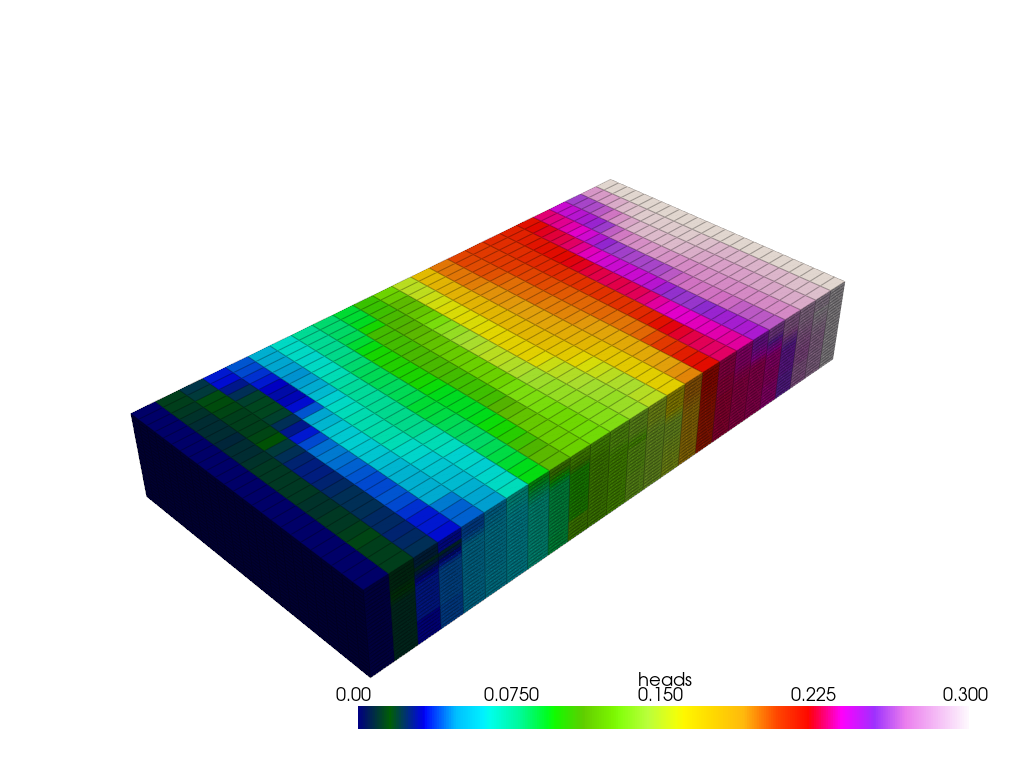

In [96]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(heads, name="heads")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="heads", cmap="gist_ncar", edge_opacity=0.3, clim=[0, 0.3])
# pl.show(screenshot="E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/flow_NR_he.png", window_size=[1300, 900], auto_close=False)

pl.show()

In [97]:
heads = archpy_flow.get_heads()

Text(0, 0.5, 'Z [m]')

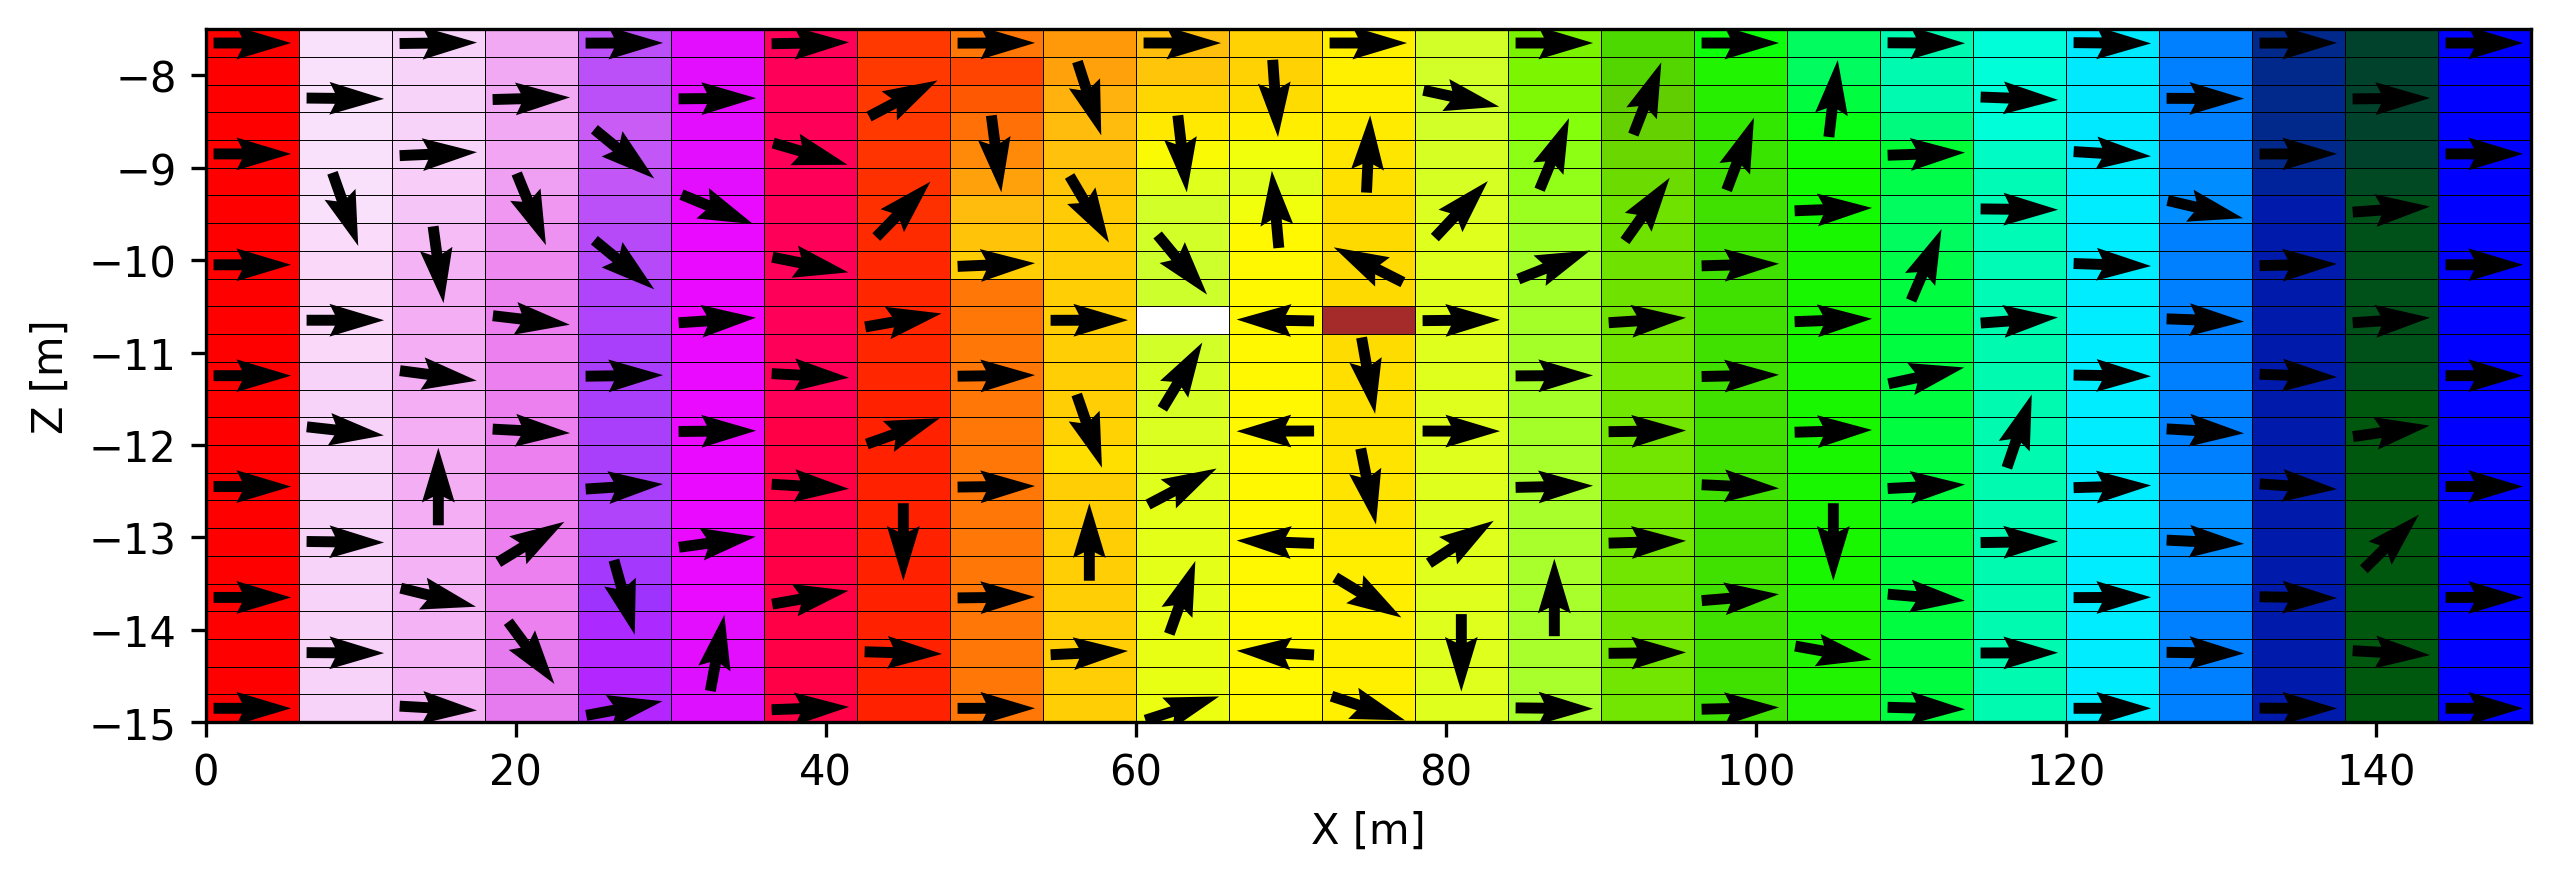

In [98]:
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300)
cross_section = PlotCrossSection(model=gwf, line={"row": 12})
# cross_section.plot_array(np.log10(gwf.npf.k.array), cmap="Blues", ax=ax)
cross_section.plot_array(heads, cmap="gist_ncar", ax=ax)
cross_section.plot_bc("CHD-1", color="red", ax=ax)
cross_section.plot_bc("CHD-2", color="blue", ax=ax)
cross_section.plot_bc("WEL-INJ", color="brown", ax=ax)
cross_section.plot_bc("WEL-PROD", color="white", ax=ax)
cross_section.plot_vector(qx, qy, qz, color="black", normalize=True, kstep=2, hstep=2, ax=ax, scale=30)
cross_section.plot_grid(linewidth=0.2, color="black")
# fig.savefig("E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/flow_NR_he_cross_section.png", dpi=300, bbox_inches="tight")
plt.xlabel("X [m]")
plt.ylabel("Z [m]")

In [99]:
np.random.seed(15)

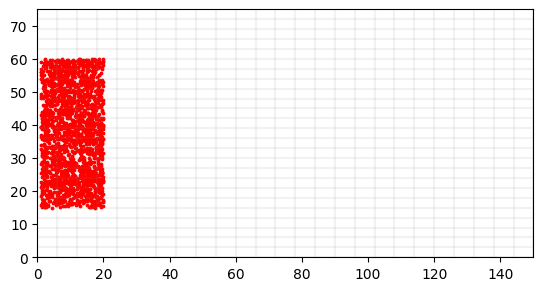

In [100]:
n = 2000
xp = np.random.uniform(1, 20, n)
yp = np.random.uniform(T1.yg[-1]*0.2 + T1.yg[0], T1.yg[-1]*0.8, n)
zp = np.random.uniform(-9, -11, n)
list_p_coords = []
for i in range(n):
    list_p_coords.append((xp[i], yp[i], zp[i]))
plt.scatter(xp, yp, c="red", s=3)
gwf.modelgrid.plot(alpha=.1)

In [101]:
archpy_flow.prt_create(prt_name="test_prt", workspace="ws_prt", trackdir="forward", list_p_coords=list_p_coords)
archpy_flow.set_porosity(prop_key="Porosity", iu=0, ifa=0, ip=0)
archpy_flow.prt_run(silent=False)

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model test_prt...
    writing model name file...
    writing package mip...
    writing package dis...
    writing package prp...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:42:11 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to furthe

In [93]:
df_all = archpy_flow.prt_get_pathlines()

In [94]:
t_well_layhe = []
t_bc_layhe = []
for i in range(1, 2000):
    xmax = df_all.loc[df_all.irpt==i].iloc[-1].x
    if xmax < 65:
        t_well_layhe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)
    else:
        t_bc_layhe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)

t_well_layhe = np.array(t_well_layhe)
t_bc_layhe = np.array(t_bc_layhe)
np.save("t_well_nrhe.npy", t_well_layhe)
np.save("t_bc_nrhe.npy", t_bc_layhe)

## Modflow grid mode heterogeneous

Create a refined grid

In [49]:
import flopy
from flopy.utils.gridgen import Gridgen
from flopy.export.vtk import Vtk

gridgen_path = "../../../../exe/gridgen.exe"

In [50]:
nlay = 10
nrow = 26
ncol = 40
Lx = 150
Ly = 75
delr = Lx / ncol
delc = Ly / nrow
top = -7.5

ox = 0
oy = 0
oz = -15
dz = (oz - top) / nlay
botm = np.linspace(top + dz, oz, nlay)

sim = flopy.mf6.MFSimulation(
    sim_name="asdf", sim_ws="ws", exe_name="mf6")
tdis = flopy.mf6.ModflowTdis(sim, time_units="DAYS", perioddata=[[1.0, 1, 1.0]])
ms = flopy.mf6.ModflowGwf(sim, modelname="asdf", save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xorigin=0,  # gridgen will be applied on a grid with origin at 0, 0
    yorigin=0,
)

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws="gridgen_ws", exe_name=gridgen_path) 

well1_coord = (T1.xg[T1.nx // 2], T1.yg[T1.ny // 2])
well2_coord = (T1.xg[int(T1.nx // 2.5)], T1.yg[T1.ny // 2])
points = [well1_coord, well2_coord]
g.add_refinement_features(points, "point", 3, range(nlay))
refshp0 = "gridgen_ws/" + "rf0"

polygon = [
    [
        (50, 30),
        (50, 45),
        (80, 45),
        (80, 30),
        (50, 30),
    ]
]
polygon = np.array(polygon)
g.add_refinement_features([polygon], "polygon", 1, range(nlay))


In [51]:
g.build(verbose=False)

Text(0.5, 0, 'X [m]')

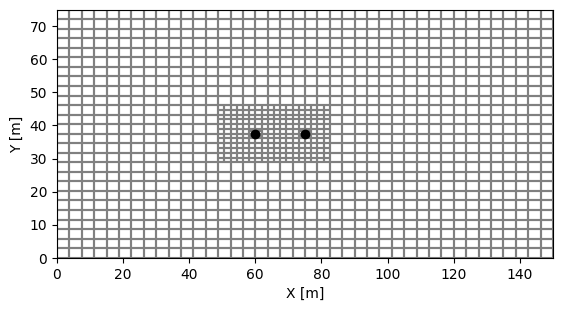

In [52]:
%matplotlib inline

ms.dis.remove()
disv_gridprops = g.get_gridprops_disv()
disv = flopy.mf6.ModflowGwfdisv(ms, **disv_gridprops, xorigin=ox, yorigin=oy, angrot=0)  # create grid this time with the origin at ox, oy
# disu = flopy.mf6.ModflowGwfdisu(ms, **g.get_gridprops_disu6(), xorigin=ox, yorigin=oy, angrot=0)  # create grid this time with the origin at ox, oy

grid = ms.modelgrid
grid.plot(alpha=1, zorder=0)

plt.scatter(T1.xg[T1.nx // 2], T1.yg[T1.ny // 2], zorder=1, color="k")
plt.scatter(T1.xg[int(T1.nx // 2.5)], T1.yg[T1.ny // 2], zorder=1, color="k")

plt.ylabel("Y [m]")
plt.xlabel("X [m]")
# plt.ylim(0, 220)
# plt.xlim(-100, 220)

In [53]:
plt.close()

In [54]:
grid.nlay * grid.ncpl

12500

In [55]:
import ArchPy.ap_mf

In [56]:
archpy_flow = archpy2modflow(T1, exe_name=mf6_exe_path, model_dir="modflow_grid_hetero")  # create the modflow model
archpy_flow.create_sim(grid_mode="disv", iu=0, unit_limit=None, modflowgrid_props=g.get_gridprops_disv())  # create the simulation object and choose a certain discretization

Simulation created
To retrieve the simulation, use the get_sim() method


In [57]:
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True, xt3doptions=None, average_facies=False)  # set the hydraulic conductivity

In [58]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [59]:
from shapely.geometry import LineString

p = np.array([(0, 0), (0, 75),
 (150, 0),
 (150, 75)])

l1 = LineString([p[0], p[1]])
l2 = LineString([p[2], p[3]])

ix = fp.utils.gridintersect.GridIntersect(mfgrid=grid)

cid1 = ix.intersects(l1).cellids
cid2 = ix.intersects(l2).cellids
h1 = 0.3
h2 = 0

# create the bc (chd package on each layers)
chd_lst = []
for ilay in range(nlay):
    chd_lst += [((ilay, id1), h1) for id1 in cid1]
for ilay in range(nlay):
    chd_lst += [((ilay, id2), h2) for id2 in cid2]

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_lst, save_flows=True, pname="CHD")

In [60]:
well1_coord = (T1.xg[T1.nx // 2], T1.yg[T1.ny // 2], T1.zg[50-21])
well2_coord = (T1.xg[int(T1.nx // 2.5)], T1.yg[T1.ny // 2], T1.zg[50-21])

# add an injection well in the middle of the model
well_data = []
Q_well = 0.0015  # m3/s
T_well = 7  # temperature of the injected water
cellid_well = gwf.modelgrid.intersect(*well1_coord)
well_data.append((cellid_well, Q_well, T_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, auxiliary="TEMPERATURE", pname="WEL-INJ")

# production well
well_data = []
Q_well = -Q_well # m3/s
cellid_well = gwf.modelgrid.intersect(*well2_coord)
well_data.append((cellid_well, Q_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, pname="WEL-PROD")

In [61]:
gwf.ic.strt.set_data(0.15)

In [62]:
sim.ims.remove()
inner_dvclose = 1e-5
ims = fp.mf6.ModflowIms(sim, complexity="moderate", inner_dvclose=inner_dvclose)

In [63]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 520 based on size of stress_period_data
    writing package wel-inj...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-prod...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:42:11 with Intel(R)

(True, [])

In [ ]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(heads, name="heads")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()

pl = pv.Plotter(notebook=True)

pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="heads", cmap="gist_ncar", edge_opacity=0.3, clim=[0, 0.3])
# pl.show(screenshot="E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/flow_mg_he.png", window_size=[1300, 900], auto_close=False)

pl.show()

Actor (0x266820b2f20)
  Center:                     (75.0, 37.5, -33.75)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    0.000E+00, 1.500E+02
  Y Bounds                    0.000E+00, 7.500E+01
  Z Bounds                    -4.500E+01, -2.250E+01
  User matrix:                Identity
  Has mapper:                 True

Property (0x266820b2ec0)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Anisotropy rotation:         0.0
  Backface culling:            0
  Base ior:                    1.5
  Class name:                  "vtkOpenGLProperty"
  Coat color:                  (1.0, 1.0, 1.0)
  Coat ior:                    2.0
  Coat normal scale:           1.0
  Coat roughness:              0.0
  Coat strength:               0.0
  Color:      

In [65]:
heads = archpy_flow.get_heads()

In [66]:
plt.close()

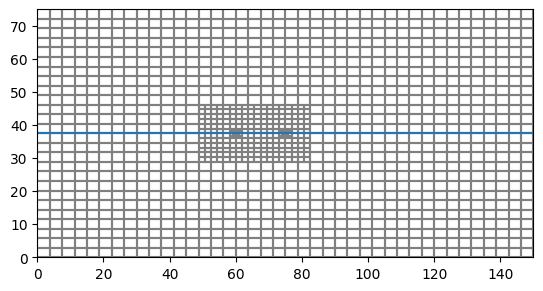

In [67]:
grid.plot()
plt.plot((0, 150), (37.5, 37.5))

Text(0, 0.5, 'Z [m]')

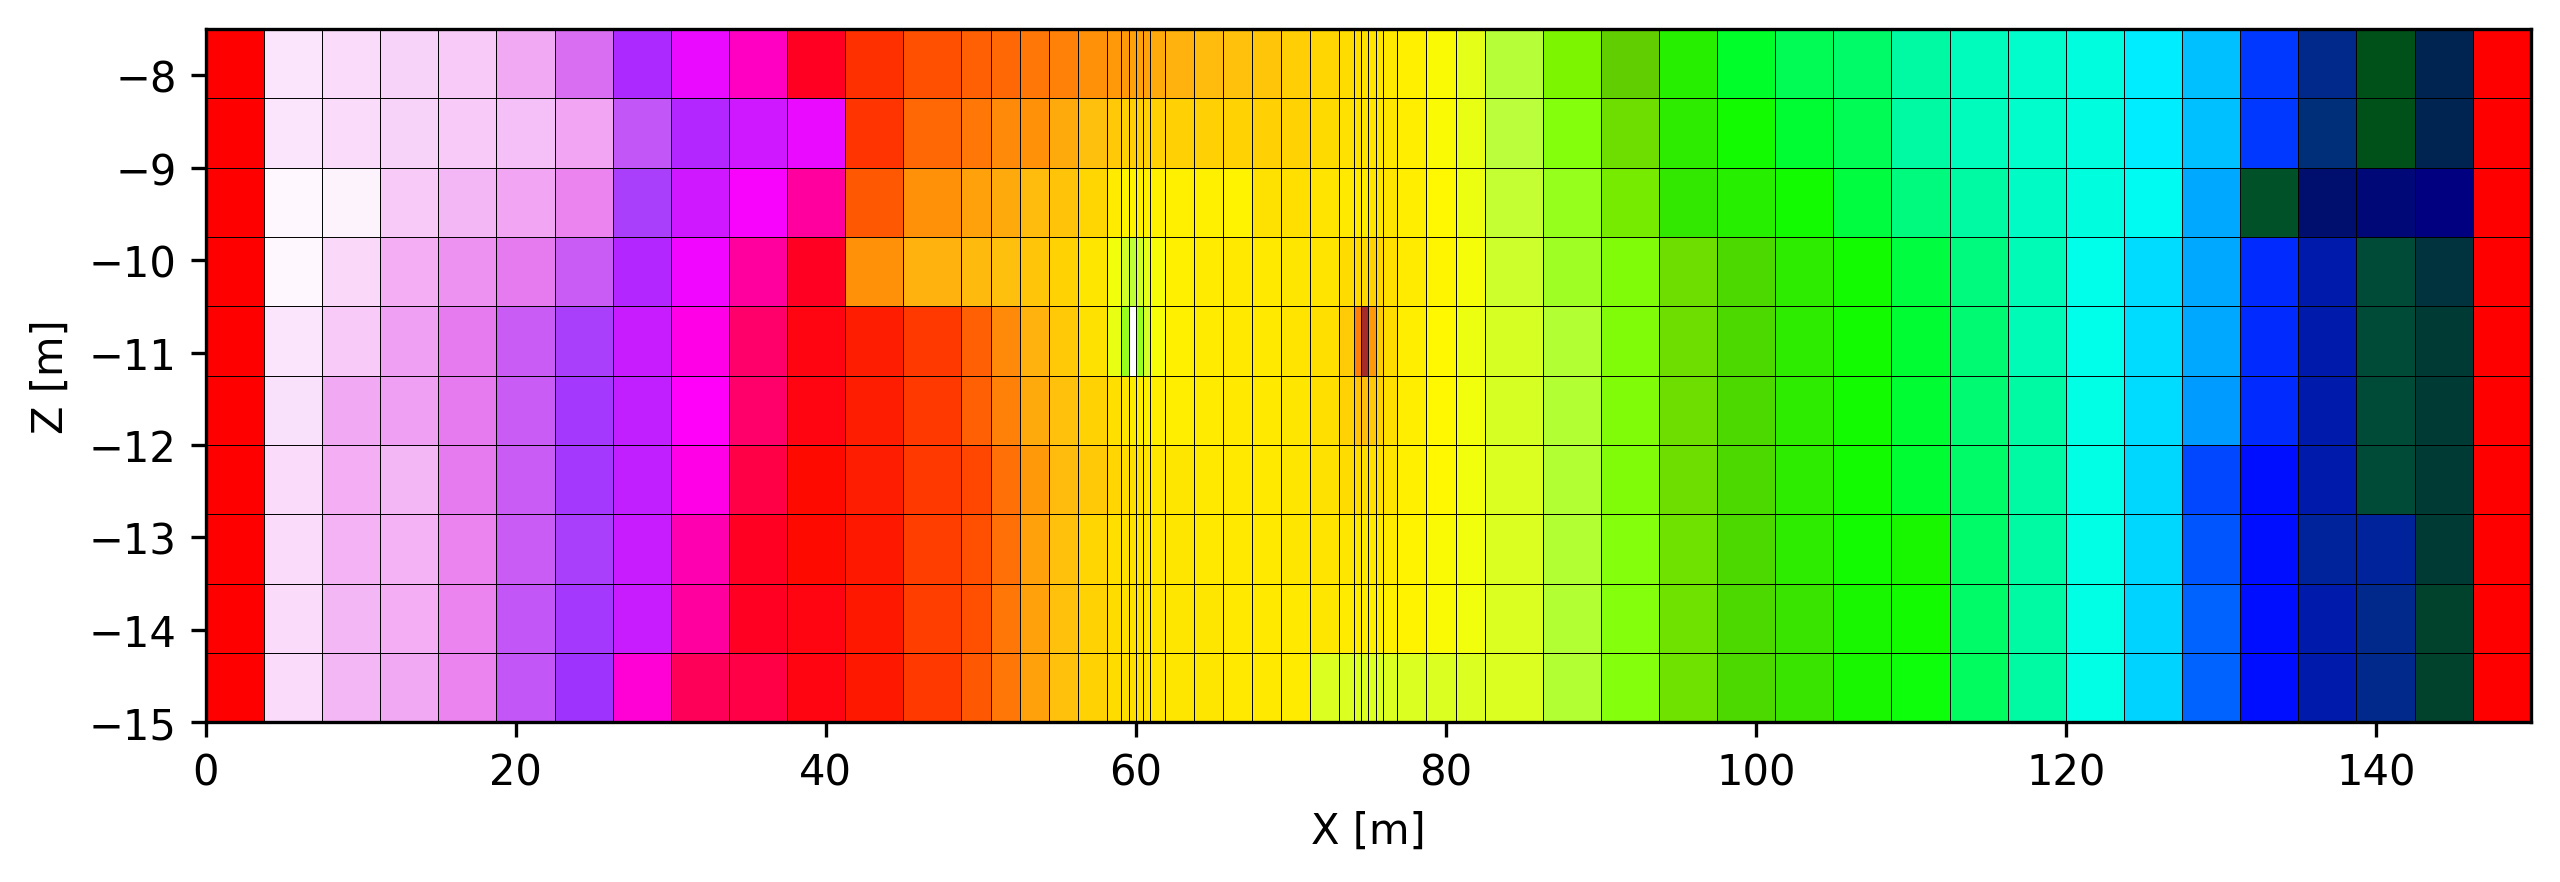

In [68]:
%matplotlib inline
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300)
cross_section = PlotCrossSection(model=gwf, line={"line": ((0, 37.5), (150, 37.5))})
# cross_section.plot_array(np.log10(gwf.npf.k.array), cmap="Blues", ax=ax)
g = cross_section.plot_array(heads, cmap="gist_ncar", ax=ax)
# plt.colorbar(g)
cross_section.plot_bc("CHD", color="red", ax=ax)
# cross_section.plot_bc("CHD-2", color="blue", ax=ax)
cross_section.plot_bc("WEL-INJ", color="brown", ax=ax)
cross_section.plot_bc("WEL-PROD", color="white", ax=ax)
# cross_section.plot_vector(qx, qy, qz, color="black", normalize=True, kstep=2, hstep=2, ax=ax, scale=30)
cross_section.plot_grid(linewidth=0.2, color="black")

plt.xlabel("X [m]")
plt.ylabel("Z [m]")
# fig.savefig("E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/flow_mg_he_cross_section.png", dpi=300, bbox_inches="tight")
# fig.savefig("../../../figures/articles/archpy 2/raw/archpy_he_cross_section.png", dpi=300, bbox_inches="tight")

In [69]:
np.random.seed(15)

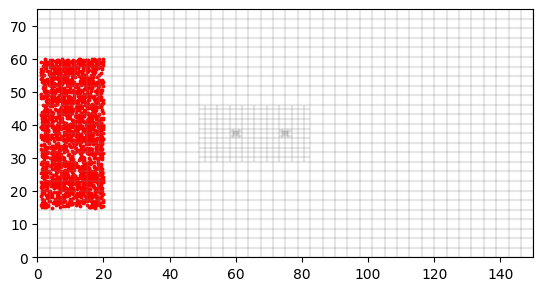

In [70]:
n = 2000
xp = np.random.uniform(1, 20, n)
yp = np.random.uniform(T1.yg[-1]*0.2 + T1.yg[0], T1.yg[-1]*0.8, n)
zp = np.random.uniform(-9, -11, n)
list_p_coords = []
for i in range(n):
    list_p_coords.append((xp[i], yp[i], zp[i]))
plt.scatter(xp, yp, c="red", s=3)
gwf.modelgrid.plot(alpha=.1)

In [71]:
archpy_flow.prt_create(prt_name="test_prt", workspace="ws_prt", trackdir="forward", list_p_coords=list_p_coords)
archpy_flow.set_porosity(prop_key="Porosity", iu=0, ifa=0, ip=0)
archpy_flow.prt_run(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model test_prt...
    writing model name file...
    writing package mip...
    writing package disv...
    writing package prp...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:42:11 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to furth

In [118]:
df_all = archpy_flow.prt_get_pathlines()

In [119]:
df_all

irpt  icell  kper  kstp  imdl  iprp  ilay  izone  istatus  ireason  \
0          1   4115     1     1     1     1     4      0        1        0   
1          1   4115     1     1     1     1     4      0        1        1   
2          1   4075     1     1     1     1     4      0        1        1   
3          1   4076     1     1     1     1     4      0        1        1   
4          1   4036     1     1     1     1     4      0        1        1   
...      ...    ...   ...   ...   ...   ...   ...    ...      ...      ...   
121889  2000   5967     1     1     1     1     5      0        1        1   
121890  2000   5968     1     1     1     1     5      0        1        1   
121891  2000   5969     1     1     1     1     5      0        1        1   
121892  2000   4719     1     1     1     1     4      0        1        1   
121893  2000   4720     1     1     1     1     4      0        5        3   

        trelease             t           x          y          z  name  
0            0.0  0.000000e+00   17.127536  48.665238  -9.800428   NaN  
1            0.0  5.853016e+04   17.385116  49.038462  -9.800444   NaN  
2            0.0  2.553075e+05   18.750000  49.850410  -9.878069   NaN  
3            0.0  6.559521e+05   20.455535  51.923077  -9.878295   NaN  
4            0.0  1.412968e+06   22.500000  54.374330 -10.426950   NaN  
...          ...           ...         ...        ...        ...   ...  
121889       0.0  3.894388e+08  138.750000  22.132087 -10.567114   NaN  
121890       0.0  3.896051e+08  142.500000  21.202862 -10.567071   NaN  
121891       0.0  3.896550e+08  143.767962  21.375636 -10.500000   NaN  
121892       0.0  3.898283e+08  146.250000  21.966853 -10.238454   NaN  
121893       0.0  3.898283e+08  146.250000  21.966853 -10.238454   NaN  

[121894 rows x 16 columns]

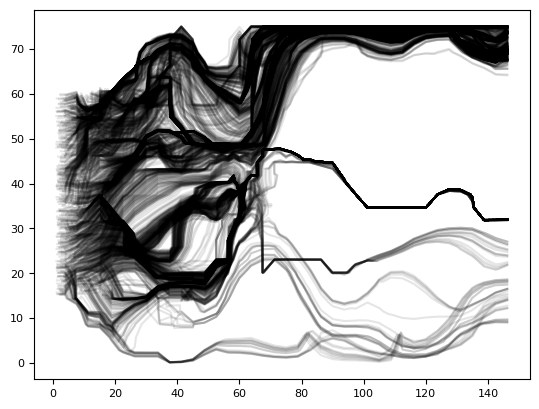

In [120]:
for i in range(1, 2000):
    df_i = df_all.loc[df_all.irpt==i]
    plt.plot(df_i.x, df_i.y, color="black", alpha=0.1)

In [121]:
t_well_layhe = []
t_bc_layhe = []
for i in range(1, 2000):
    xmax = df_all.loc[df_all.irpt==i].iloc[-1].x
    if xmax < 65:
        t_well_layhe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)
    else:
        t_bc_layhe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)

t_well_layhe = np.array(t_well_layhe)
t_bc_layhe = np.array(t_bc_layhe)
np.save("t_well_mghe.npy", t_well_layhe)
np.save("t_bc_mghe.npy", t_bc_layhe)

## ArchPy mode - homogeneous

Re make an archpy model but assuming each layer completely homogeneous.

In [102]:
## create pile

P1 = Pile(name = "P1",seed=1)

#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodelD1 = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[30,30]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[40,40]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[50,50]})])


#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method":"homogenous"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-8.5}
dic_f_C = {"f_method":"homogenous"}
C = Unit(name="C", order=2, ID = 2, color="blue", contact="onlap", dic_facies=dic_f_C, surface=Surface(dic_surf=dic_s_C, contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-9.5}
dic_f_B = {"f_method":"homogenous"}
B = Unit(name="B",order=3,ID = 3,color="purple",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB, "mean":-13}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=4, ID = 4,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[30,30,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[20,20, 5]})],alpha=0,name="K_vario_2")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_2])
D.add_facies([facies_1])
C.add_facies([facies_4])

# property model

# K
# cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.5, "r":[10, 10, 10]}),
#                                   ("cubic", {"w":0.5, "r":[15, 15, 15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.25, "r":[25, 25, 25]})])

list_facies = [facies_1, facies_2, facies_4, facies_7]
means = [-4, -2.3, -8, -10]
prop_model = ArchPy.base.Prop("K",
                              facies = list_facies,
                              covmodels = [cm_prop2, cm_prop2, cm_prop2, cm_prop2],
                                means = means,
                                int_method = "homogenous",
                                vmin = -10,
                                vmax = -1
                                )

# porosity
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.001, "r":[15, 15, 15]})])

porosity = ArchPy.base.Prop("Porosity",
                            facies = list_facies,
                            covmodels = [cm_prop2, cm_prop2, cm_prop2, cm_prop2],
                            means = [0.3, 0.3, 0.1, 0.05],
                            int_method = "homogenous",
                            vmin = 0,
                            vmax = 0.4
                            )

# alh
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.01, "r":[10, 10, 10]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.01, "r":[25, 25, 5]})])

long_disp = ArchPy.base.Prop("long_disp",
                            facies = list_facies,
                            covmodels = None,
                            means = [1, 2, 10, .1],
                            int_method = "homogenous",
                            vmin = 0
                            )
top = np.ones([ny,nx])*z1
bot = np.ones([ny,nx])*z0
T1 = Arch_table(name = "P1",seed=3)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot)
T1.add_prop([prop_model, porosity, long_disp])
T1.compute_surf(1)
T1.compute_facies(1)
T1.compute_prop(1)

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added
Facies basement added to unit A
Facies Gravel added to unit B
Facies Sand added to unit D
Facies Clay added to unit C
Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Property K added
Property Porosity added
Property long_disp added
Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.016014575958251953 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.015013694763183594 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.01701617240905

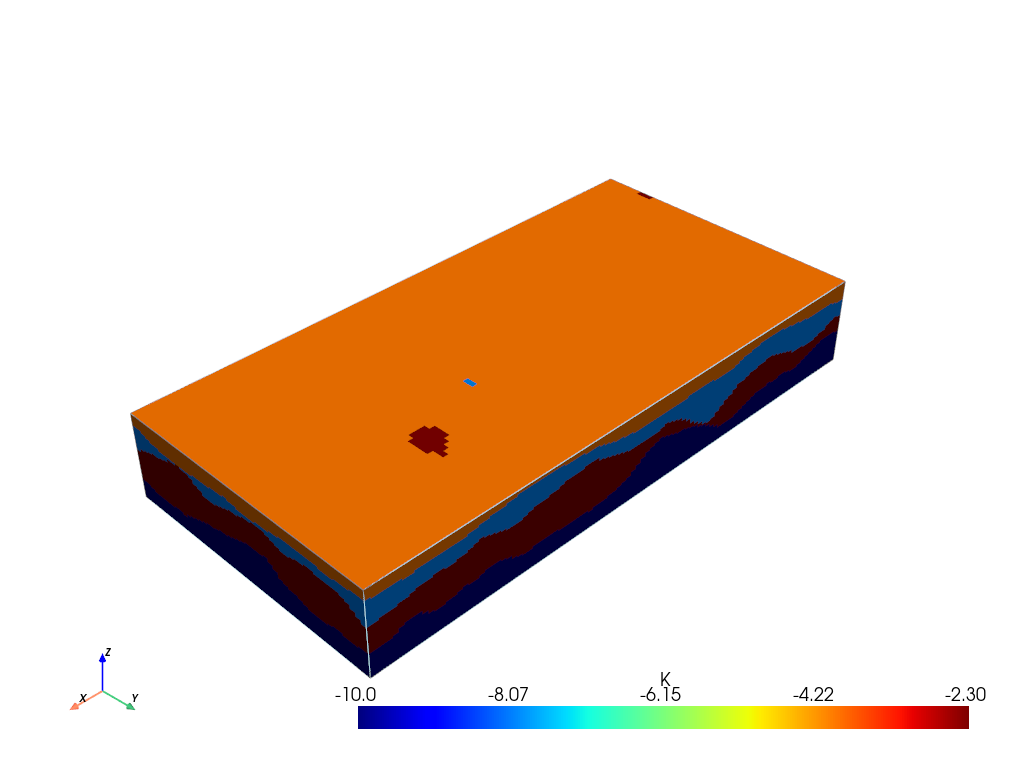

In [103]:
T1.plot_prop("K", cmap="jet", v_ex=3)

In [104]:
archpy_flow = archpy2modflow(T1, exe_name=mf6_exe_path, model_dir="archpy_mode_homo")  # create the modflow model
archpy_flow.create_sim(grid_mode="archpy", iu=0, unit_limit=None)  # create the simulation object and choose a certain discretization
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True,)  # set the hydraulic conductivity

Simulation created
To retrieve the simulation, use the get_sim() method


In [105]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [106]:
import flopy as fp

In [107]:
sim.ims.remove()
inner_dvclose = 1e-5
ims = fp.mf6.ModflowIms(sim, complexity="moderate", inner_dvclose=inner_dvclose)

In [108]:
import flopy as fp

In [109]:
# add BC at left and right on all layers
h1 = .3
h2 = 0
T_1 = 10  # temperature at left boundary
T_2 = 10  # temperature at right boundary
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1, T_1))

chd1 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-1")

chd_data = []
a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2, T_2))

chd2 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-2")

Wells at ($75.0, 25.0, 4.5$) and ($60.0, 25.0, 4.5$)

In [110]:
# add an injection well in the middle of the model
well_data = []
Q_well = 0.0015  # m3/s
T_well = 7  # temperature of the injected water
cellid_well = (21, T1.ny // 2, T1.nx // 2)
well_data.append((cellid_well, Q_well, T_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, auxiliary="TEMPERATURE", pname="WEL-INJ")

# production well
well_data = []
Q_well = -0.0015  # m3/s
cellid_well = (21, T1.ny // 2, int(T1.nx // 2.5))
well_data.append((cellid_well, Q_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, pname="WEL-PROD")

In [111]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2500 based on size of stress_period_data
    writing package chd-2...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2500 based on size of stress_period_data
    writing package wel-inj...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-prod...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURV

(True, [])

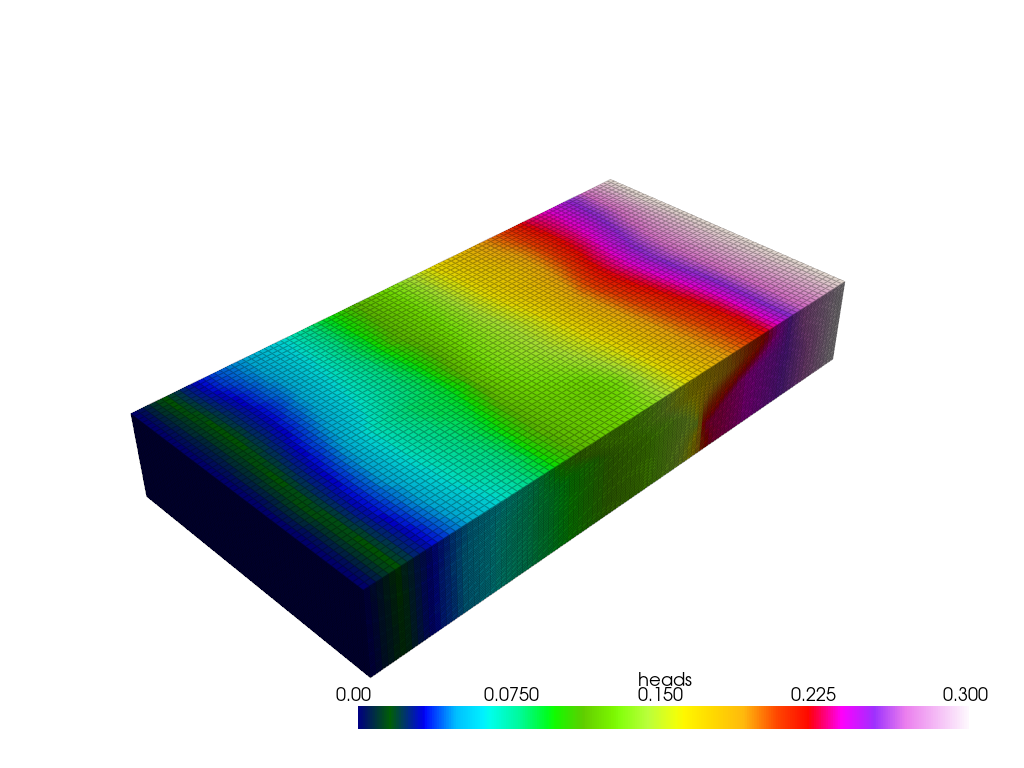

In [112]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(heads, name="heads")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
# pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="heads", cmap="viridis", edge_opacity=0.3, clim=[0, 0.3])

pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="heads", cmap="gist_ncar", edge_opacity=0.3, clim=[0, 0.3])
# pl.show(screenshot="E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/flow_archpy_ho.png", window_size=[1300, 900], auto_close=False)
pl.show()

In [113]:
heads = archpy_flow.get_heads()

Text(0, 0.5, 'Z [m]')

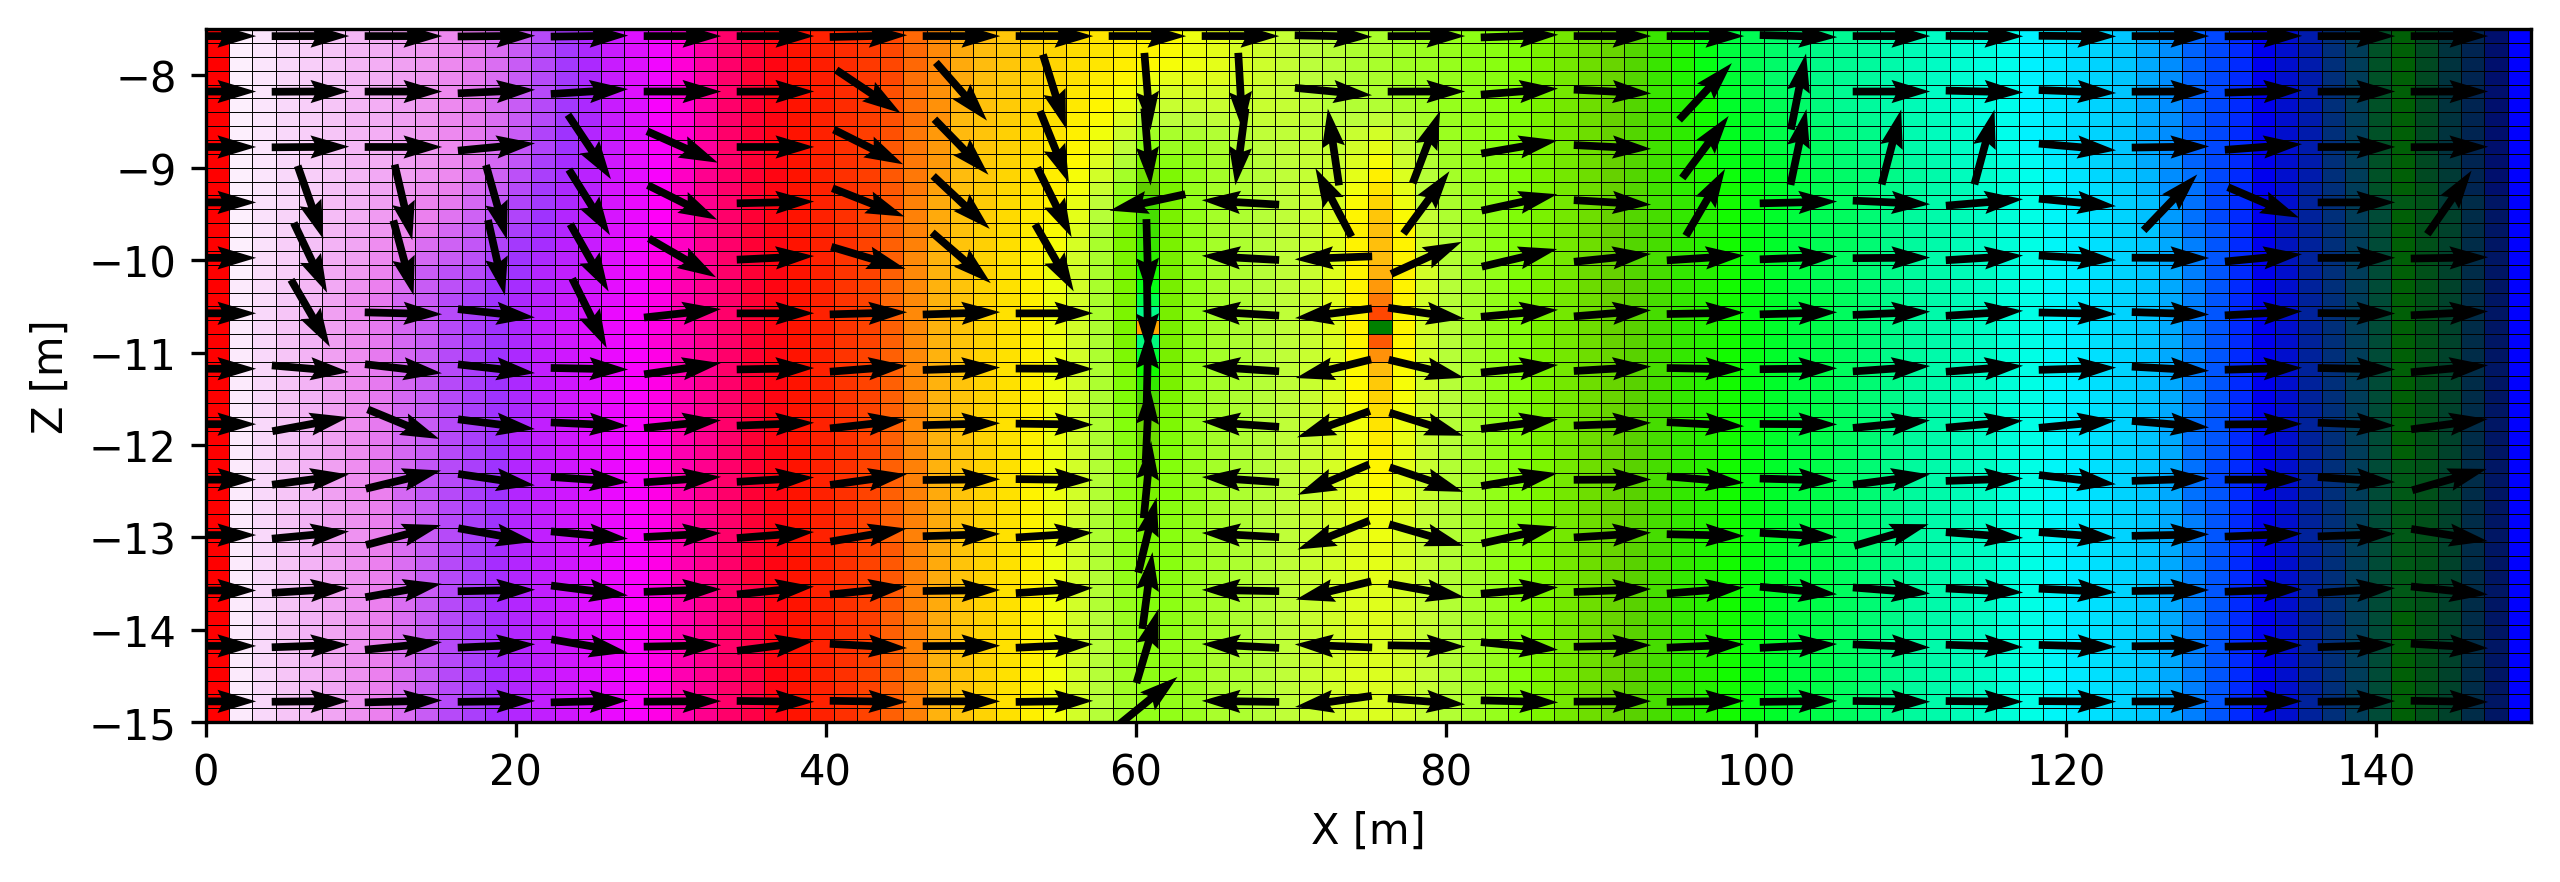

In [114]:
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300)
cross_section = PlotCrossSection(model=gwf, line={"row": 25})
cross_section.plot_array(heads, cmap="gist_ncar", ax=ax)
cross_section.plot_bc("CHD-1", color="red", ax=ax)
cross_section.plot_bc("CHD-2", color="blue", ax=ax)
cross_section.plot_bc("WEL-INJ", color="green", ax=ax)
cross_section.plot_bc("WEL-PROD", color="orange", ax=ax)
cross_section.plot_vector(qx, qy, qz, color="black", normalize=True, kstep=4, hstep=4, ax=ax, scale=30)
cross_section.plot_grid(linewidth=0.2, color="black")

plt.xlabel("X [m]")
plt.ylabel("Z [m]")

# fig.savefig("E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/flow_archpy_ho_cross_section.png", dpi=300, bbox_inches="tight")

In [115]:
np.random.seed(15)

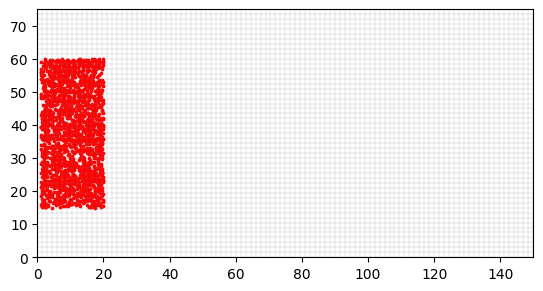

In [116]:
n = 2000
xp = np.random.uniform(1, 20, n)
yp = np.random.uniform(T1.yg[-1]*0.2 + T1.yg[0], T1.yg[-1]*0.8, n)
zp = np.random.uniform(-9, -11, n)
list_p_coords = []
for i in range(n):
    list_p_coords.append((xp[i], yp[i], zp[i]))
plt.scatter(xp, yp, c="red", s=3)
gwf.modelgrid.plot(alpha=.1)

In [117]:
archpy_flow.prt_create(prt_name="test_prt", workspace="ws_prt", trackdir="forward", list_p_coords=list_p_coords)
archpy_flow.set_porosity(prop_key="Porosity", iu=0, ifa=0, ip=0)
archpy_flow.prt_run(silent=False)

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model test_prt...
    writing model name file...
    writing package mip...
    writing package dis...
    writing package prp...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:42:11 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to furthe

In [138]:
df_all = archpy_flow.prt_get_pathlines()

In [139]:
t_well_layhe = []
t_bc_layhe = []
for i in range(1, 2000):
    xmax = df_all.loc[df_all.irpt==i].iloc[-1].x
    if xmax < 65:
        t_well_layhe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)
    else:
        t_bc_layhe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)

t_well_layhe = np.array(t_well_layhe)
t_bc_layhe = np.array(t_bc_layhe)
np.save("t_well_apho.npy", t_well_layhe)
np.save("t_bc_apho.npy", t_bc_layhe)

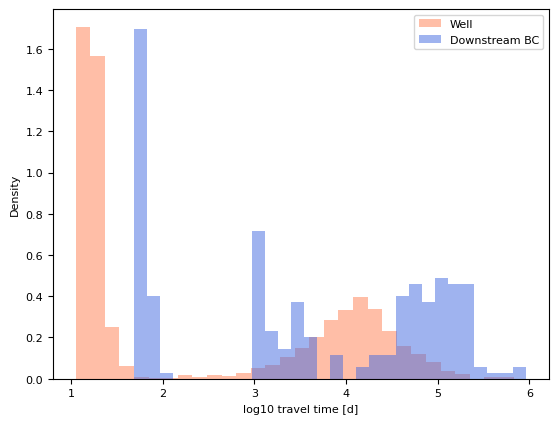

In [140]:
plt.hist(np.log10(t_well_layhe / 86400), density=True, alpha=.5, label="Well", color="coral", bins=30)
plt.hist(np.log10(t_bc_layhe / 86400), density=True, alpha=.5, label="Downstream BC", color="royalblue", bins=30)

plt.xlabel("log10 travel time [d]")
plt.ylabel("Density")

plt.legend()

## Layered homogeneous mode

In [78]:
archpy_flow = archpy2modflow(T1, exe_name=mf6_exe_path, model_dir="layered_homo")  # create the modflow model
archpy_flow.create_sim(grid_mode="layers", iu=0, unit_limit=None, lay_sep=[1, 1, 3, 1], factor_x=2, factor_y=2, factor_z=2)  # create the simulation object and choose a certain discretization
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True, k_average_method="anisotropic")  # set the hydraulic conductivity

Simulation created
To retrieve the simulation, use the get_sim() method


In [79]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [80]:
sim.ims.remove()
inner_dvclose = 1e-5
ims = fp.mf6.ModflowIms(sim, complexity="moderate", inner_dvclose=inner_dvclose)

In [81]:
# add BC at left and right on all layers
h1 = .3
h2 = 0
T_1 = 10  # temperature at left boundary
T_2 = 10  # temperature at right boundary
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1, T_1))

chd1 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-1")

chd_data = []
a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2, T_2))

chd2 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-2")

In [82]:
# add an injection well in the middle of the model
well_data = []
Q_well = 0.0015  # m3/s
T_well = 7  # temperature of the injected water
cellid_well = (2, T1.ny // 2, T1.nx // 2)
well_data.append((cellid_well, Q_well, T_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, auxiliary="TEMPERATURE", pname="WEL-INJ")

# production well
well_data = []
Q_well = -Q_well # m3/s
cellid_well = (2, T1.ny // 2, int(T1.nx // 2.5))
well_data.append((cellid_well, Q_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, pname="WEL-PROD")

In [83]:
# update the hydraulic conductivity

k_aquifer = 5e-3
archpy_flow.set_k(k=[1e-4, 1e-8, k_aquifer, k_aquifer, k_aquifer, 1e-10])

In [84]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 290 based on size of stress_period_data
    writing package chd-2...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 300 based on size of stress_period_data
    writing package wel-inj...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-prod...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package npf...
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY

(True, [])

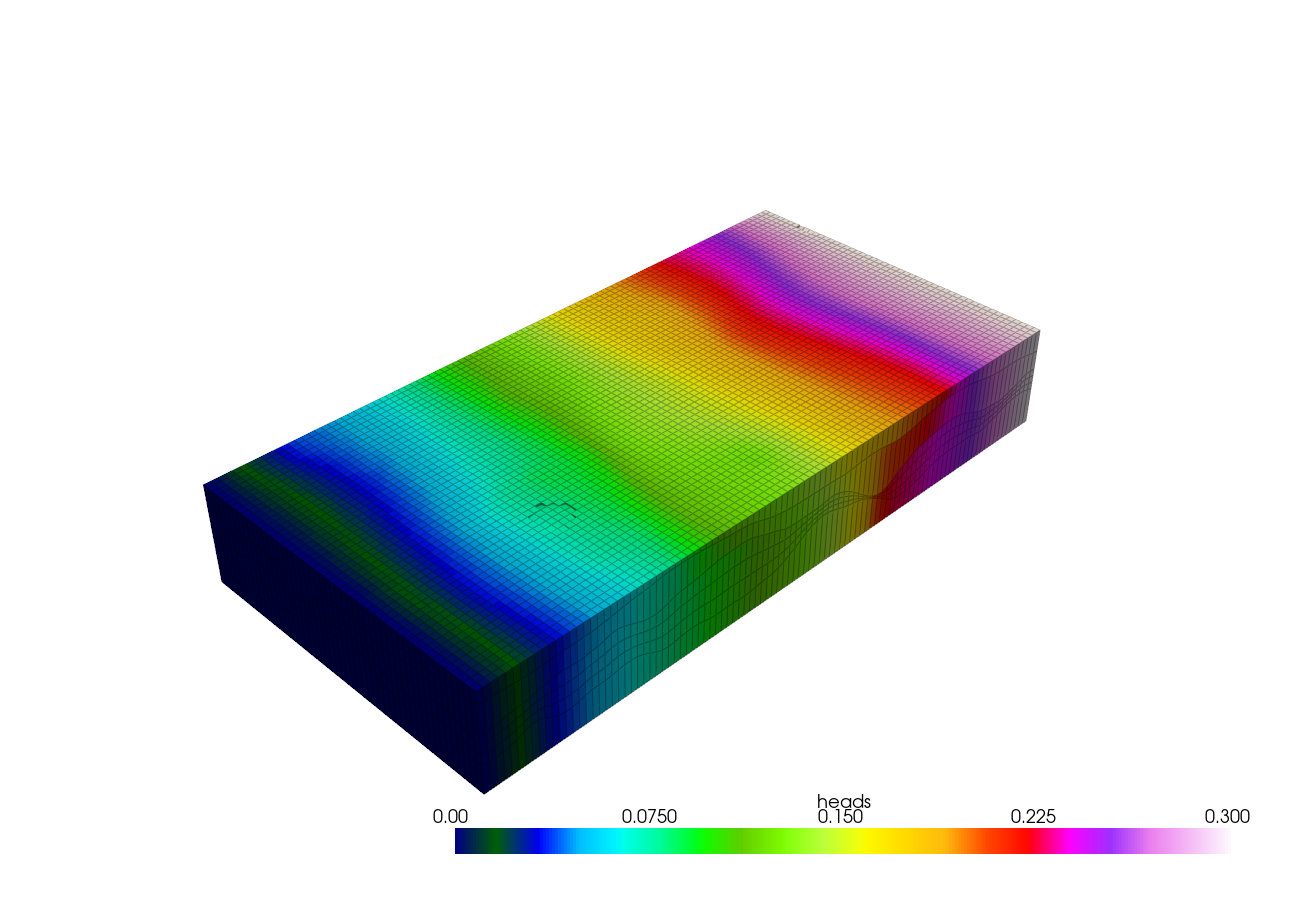

In [ ]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(heads, name="heads")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="heads", cmap="gist_ncar", edge_opacity=0.3)
# pl.show(screenshot="../../../figures/articles/archpy 2/raw/flow_lay_ho.png", window_size=[1300, 900], auto_close=False)
# pl.show(screenshot="E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/flow_lay_ho.png", window_size=[1300, 900], auto_close=False)
pl.show()

In [86]:
heads = archpy_flow.get_heads()

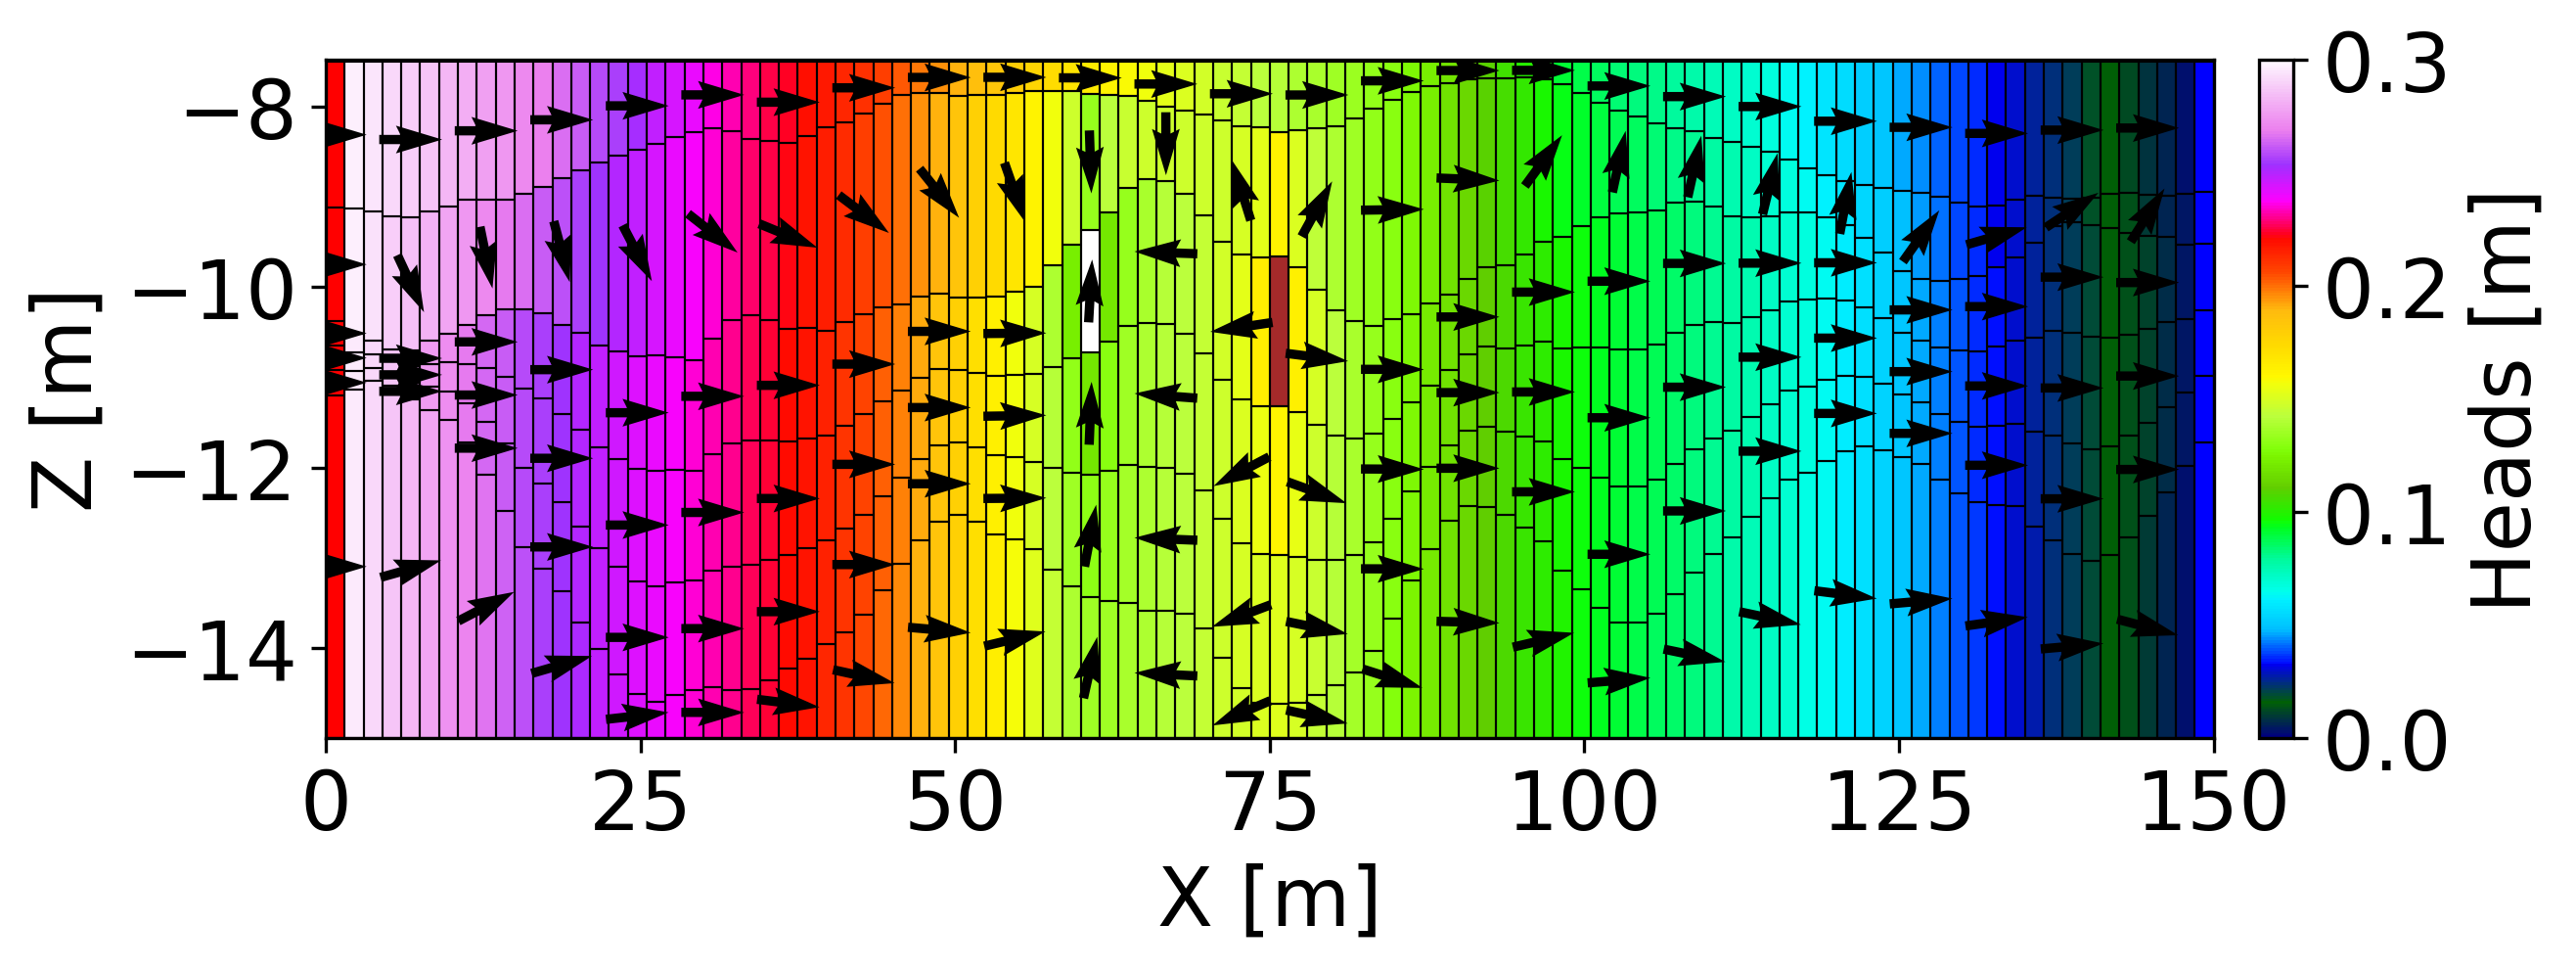

In [ ]:
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300)
cross_section = PlotCrossSection(model=gwf, line={"row": 25})
# cross_section.plot_array(np.log10(gwf.npf.k.array), cmap="Blues", ax=ax)
cont = cross_section.plot_array(heads, cmap="gist_ncar", ax=ax)
# cont = cross_section.contour_array(heads, ax=ax, levels=np.arange(0, 0.25, 0.02), linewidths=3)
# plt.clabel(cont, inline=True, fontsize=20, fmt="%.2f", colors="black")
cross_section.plot_bc("CHD-1", color="red", ax=ax)
cross_section.plot_bc("CHD-2", color="blue", ax=ax)
cross_section.plot_bc("WEL-INJ", color="brown", ax=ax)
cross_section.plot_bc("WEL-PROD", color="white", ax=ax)
cross_section.plot_vector(qx, qy, qz, color="black", normalize=True, hstep=4, kstep=1, ax=ax, scale=30)
cross_section.plot_grid(linewidth=0.5, color="black")
plt.colorbar(cont, ax=ax, label="Heads [m]", orientation="vertical", pad=0.02)
plt.xlabel("X [m]")
plt.ylabel("Z [m]")

# fig.savefig("E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/flow_lay_ho_cross_section.png", dpi=300, bbox_inches="tight")

In [151]:
np.random.seed(15)

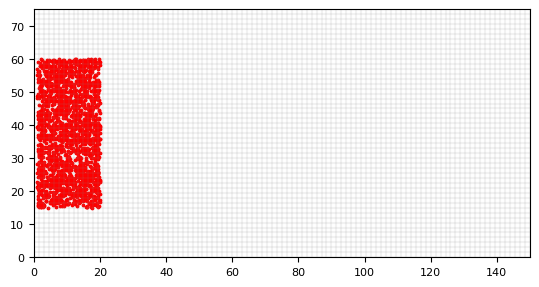

In [152]:
n = 2000
xp = np.random.uniform(1, 20, n)
yp = np.random.uniform(T1.yg[-1]*0.2 + T1.yg[0], T1.yg[-1]*0.8, n)
zp = np.random.uniform(-9, -11, n)
list_p_coords = []
for i in range(n):
    list_p_coords.append((xp[i], yp[i], zp[i]))
plt.scatter(xp, yp, c="red", s=3)
gwf.modelgrid.plot(alpha=.1)

In [153]:
archpy_flow.prt_create(prt_name="test_prt", workspace="ws_prt", trackdir="forward", list_p_coords=list_p_coords)
archpy_flow.set_porosity(prop_key="Porosity", iu=0, ifa=0, ip=0)
archpy_flow.prt_run(silent=False)

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model test_prt...
    writing model name file...
    writing package mip...
    writing package dis...
    writing package prp...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:42:11 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to furthe

In [154]:
df_all = archpy_flow.prt_get_pathlines()

In [155]:
t_well_layhe = []
t_bc_layhe = []
for i in range(1, 2000):
    xmax = df_all.loc[df_all.irpt==i].iloc[-1].x
    if xmax < 65:
        t_well_layhe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)
    else:
        t_bc_layhe.append(df_all.loc[df_all.irpt==i].iloc[-1].t)

t_well_layhe = np.array(t_well_layhe)
t_bc_layhe = np.array(t_bc_layhe)
np.save("t_well_layho.npy", t_well_layhe)
np.save("t_bc_layho.npy", t_bc_layhe)

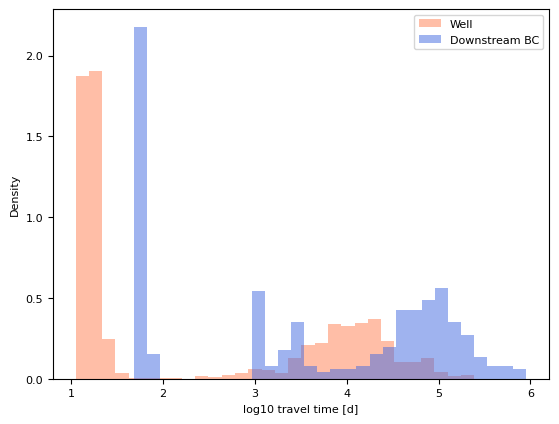

In [156]:
plt.hist(np.log10(t_well_layhe / 86400), density=True, alpha=.5, label="Well", color="coral", bins=30)
plt.hist(np.log10(t_bc_layhe / 86400), density=True, alpha=.5, label="Downstream BC", color="royalblue", bins=30)

plt.xlabel("log10 travel time [d]")
plt.ylabel("Density")

plt.legend()

In [6]:
t_well_layhe = np.load("t_well_layhe.npy")
t_bc_layhe = np.load("t_bc_layhe.npy")
t_well_aphe = np.load("t_well_aphe.npy")
t_bc_aphe = np.load("t_bc_aphe.npy")
t_well_layho = np.load("t_well_layho.npy")
t_bc_layho = np.load("t_bc_layho.npy")
t_well_apho = np.load("t_well_apho.npy")
t_bc_apho = np.load("t_bc_apho.npy")
t_well_nrhe = np.load("t_well_nrhe.npy")
t_bc_nrhe = np.load("t_bc_nrhe.npy")
t_well_mghe = np.load("t_well_mghe.npy")
t_bc_mghe = np.load("t_bc_mghe.npy")

In [7]:
df_plot_well = pd.DataFrame([np.log10(t_well_aphe / 86400),np.log10(t_well_apho / 86400), np.log10(t_well_layhe / 86400), np.log10(t_well_apho / 86400), np.log10(t_well_nrhe / 86400), np.log10(t_well_mghe / 86400)]).T

df_plot_bc = pd.DataFrame([np.log10(t_bc_aphe / 86400), np.log10(t_bc_apho / 86400), np.log10(t_bc_layhe / 86400), np.log10(t_bc_layho / 86400), np.log10(t_bc_nrhe / 86400), np.log10(t_bc_mghe / 86400)]).T
df_plot_bc.columns = ["Ap-he", "Ap-ho", "Lay-he", "Lay-ho", "NR-he", "MG-he"]
df_plot_well.columns = ["Ap-he", "Ap-ho", "Lay-he", "Lay-ho", "NR-he", "MG-he"]


In [8]:
import seaborn as sns

In [9]:
sns.set_palette("colorblind")

In [12]:
# default fontsize
matplotlib.rcParams.update({'font.size': 10})

C:\Users\schorppl\AppData\Local\Temp\ipykernel_19008\2907798700.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45, ha="center")
C:\Users\schorppl\AppData\Local\Temp\ipykernel_19008\2907798700.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45, ha="center")


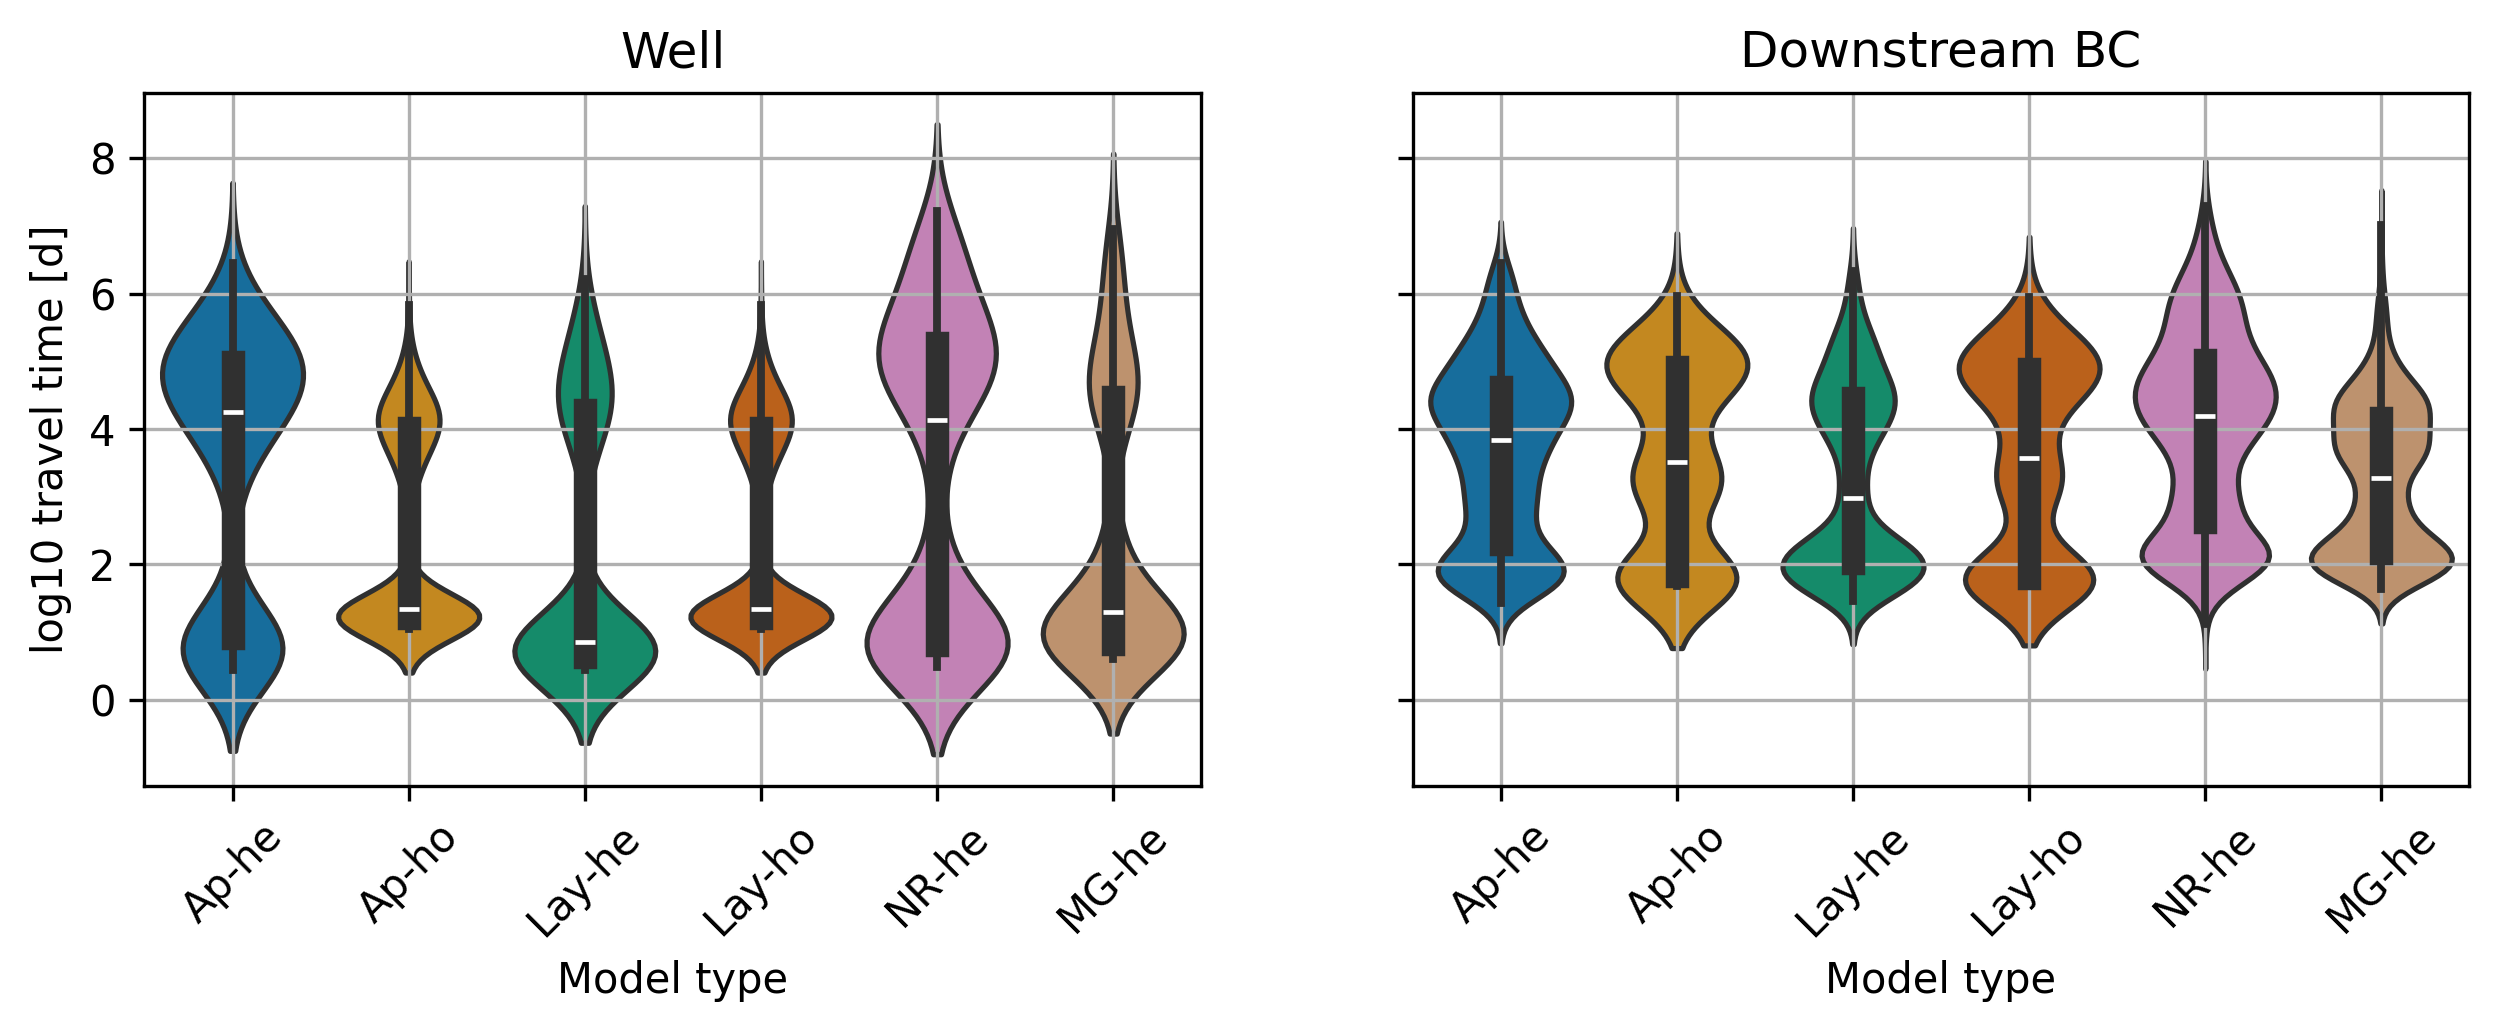

In [13]:
fig, ax= plt.subplots(1, 2, figsize=(10, 3), dpi=300, sharey=True)

axi = ax[0]
sns.violinplot(data=df_plot_well, ax=axi)
axi.set_ylabel("log10 travel time [d]")
axi.set_title("Well")

axi = ax[1]
sns.violinplot(data=df_plot_bc, ax=axi)

axi.set_title("Downstream BC")

# rotate x labels
for ax_i in ax:
    ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45, ha="center")
    ax_i.set_xlabel("Model type")
    ax_i.grid(True)

fig.savefig("E:/switchdrive/Post_doc/figures/articles/archpy 2/raw/travel_time_violin.png", dpi=300, bbox_inches="tight")